In [5]:
import os
import subprocess
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, levene, ranksums
from sklearn.linear_model import LinearRegression
import numpy as np
import pyBigWig
import math
import re
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import multipletests
from statsmodels.multivariate.manova import MANOVA
from scipy import stats
import statsmodels.api as sm
from matplotlib import gridspec
from matplotlib.patches import Patch
import matplotlib.colors as mcolors

In [6]:
# Samples loading and configuration

# both mapq and adjusted
#base_results_dir = os.path.expanduser('/labmed/workspace/lotta/finaletoolkit/carsten/outputs/adjust_wps')

# neither mapq nor adjusted
base_results_dir = os.path.expanduser('/labmed/workspace/lotta/finaletoolkit/results_snakemake')

# only mapq
#base_results_dir = os.path.expanduser('//labmed/workspace/lotta/finaletoolkit/carsten/outputs/mapq_wps')
cancer_samples = [
    "EE88290",
    "EE88291",
    "EE88292",
    "EE88293",
    "EE88294",
    "EE88295",
    #"EE88296",
    #"EE88297",
    #"EE88298",
    #"EE88299",
    #"EE88300",
    #"EE88301",
    #"EE88302",
    #"EE88303",
    #"EE88304",
    #"EE88305",
    #"EE88306",
    #"EE88307",
    #"EE88308",
    #"EE88309",
    #"EE88310",
    #"EE88311",
    #"EE88312",
    #"EE88313",
    #"EE88314",
    #"EE88315",
    #"EE88316",
    #"EE88317",
    #"EE88318",
    #"EE88319",
    #"EE88320",
    #"EE88321",
    #"EE88322",
    #"EE88323",
    #"EE88324","""
]

control_samples = [
    "EE87935",
    "EE87936",
    "EE87937",
    "EE87938",
    "EE87939",
    "EE87940",
    "EE87941",
    "EE87942",
    "EE87943",
    #"EE87944",
    #"EE87945",
    #"EE87946",
    #"EE87947",
    #"EE87948",
    #"EE87949",
    #"EE87950",
    #"EE87951",
    #"EE87952",
    #"EE87953",
    #"EE87954",
    #"EE87955",
    #"EE87956",
    #"EE87957",
    #"EE87958",
    #"EE87960",
    #"EE87961",
    #"EE87962",
    #"EE87963",
    #"EE87964",
    #"EE87965",
    #"EE87966",
    #"EE87967",
    #"EE87968",
    #"EE87969",
    #"EE87970","""
]



def bigwig_summary(bigwig_path, chrom, start, end, n_bins=1):
    bw = pyBigWig.open(bigwig_path)
    bin_size = (end - start) // n_bins
    results = []
    for i in range(n_bins):
        b_start = start + i*bin_size
        b_end = start + (i+1)*bin_size if i < n_bins-1 else end
        vals = bw.values(chrom, b_start, b_end)
        vals = [v for v in vals if v is not None and not math.isnan(v)]
        results.append(sum(vals)/len(vals) if vals else 0)
    bw.close()
    return results

all_samples = cancer_samples + control_samples
print(f"Configuration loaded for {len(all_samples)} samples.")
print(all_samples)

Configuration loaded for 15 samples.
['EE88290', 'EE88291', 'EE88292', 'EE88293', 'EE88294', 'EE88295', 'EE87935', 'EE87936', 'EE87937', 'EE87938', 'EE87939', 'EE87940', 'EE87941', 'EE87942', 'EE87943']


In [ ]:
#both mapq and adjusted
#bedgraph_dir = os.path.expanduser('/labmed/workspace/lotta/finaletoolkit/carsten/outputs/bedgraph_adjust_wps')

#neither mapq nor adjusted
bedgraph_dir = os.path.expanduser('/labmed/workspace/lotta/finaletoolkit/results_snakemake/wps_bedgraphs')

#only mapq
#bedgraph_dir = os.path.expanduser('/labmed/workspace/lotta/finaletoolkit/carsten/outputs/bedgraphs_mapq')
#if os.path.exists("/labmed/workspace/lotta/finaletoolkit/dataframes_notebook/combined_df.parquet"):
#    combined_df = pd.read_parquet("/labmed/workspace/lotta/finaletoolkit/dataframes_notebook/combined_df.parquet")
#else:
all_dfs = []
exclude_chr = ['chrX', 'chrY']

for sample_id in cancer_samples:
    file_path = os.path.join(bedgraph_dir, f"{sample_id}.bedgraph")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, sep='\t', header=None, names=['chrom', 'start', 'end', 'wps_value', 'sample'])
        df = df[~df['chrom'].str.startswith(tuple(exclude_chr))]
        df['group'] = 'Cancer'
        df['sample'] = sample_id
        all_dfs.append(df)
    else:
        print(f"Warning: File for cancer sample not found: {file_path}")

for sample_id in control_samples:
    file_path = os.path.join(bedgraph_dir, f"{sample_id}.bedgraph")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, sep='\t', header=None, names=['chrom', 'start', 'end', 'wps_value', 'sample'])
        df['group'] = 'Control'
        df['sample'] = sample_id
        all_dfs.append(df)
    else:
        print(f"Warnng: File for control sample not found: {file_path}")

combined_df = pd.concat(all_dfs, ignore_index=True)

print(f"Data of {len(all_dfs)} samples successfully loaded.")
combined_df.to_parquet("dataframes_notebook/combined_df.parquet", index=False)

In [31]:
print(combined_df[combined_df['chrom'] == 'chr22'].head())

Empty DataFrame
Columns: [chrom, start, end, wps_value, sample, group, bin]
Index: []


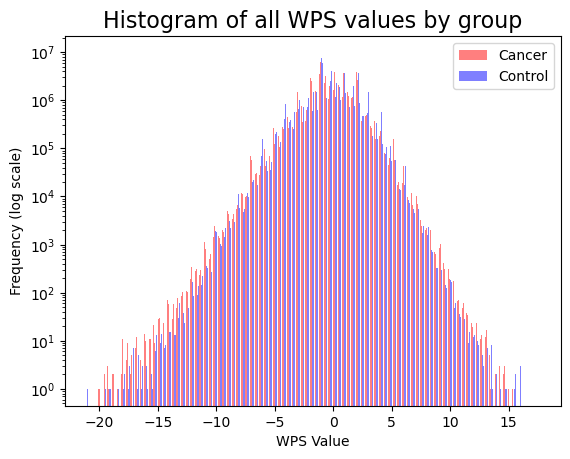

In [4]:
plt.hist(
    [combined_df.loc[combined_df['group']=='Cancer','wps_value'], 
     combined_df.loc[combined_df['group']=='Control','wps_value']],
    bins=1000, color=['red','blue'], alpha=0.5, label=['Cancer','Control']
)
plt.yscale('log')
plt.xlabel("WPS Value")
plt.ylabel("Frequency (log scale)")
plt.title("Histogram of all WPS values by group", fontsize=16)
plt.legend()
plt.show()


In [ ]:
# 1. BIN WIDE ANALYSIS, Binning the genome

bin_size = 5000000
#if os.path.exists(f"dataframes_notebook/binned_combined_df_{bin_size}.parquet"):
#        binned_combined_df = pd.read_parquet(f"dataframes_notebook/binned_combined_df_{bin_size}.parquet")
#else:
combined_df['bin'] = combined_df['start'] // bin_size
binned_combined_df = combined_df.groupby(['sample', 'group', 'chrom', 'bin'])['wps_value'].mean()
binned_combined_df = binned_combined_df.reset_index()
print(binned_combined_df[binned_combined_df['chrom'] =='chr2'])
binned_combined_df['wps_value'] = binned_combined_df.groupby(['chrom', 'bin'])['wps_value'].transform(lambda x: x.fillna(x.median()))
binned_combined_df.to_parquet(f"dataframes_notebook/binned_combined_df_{bin_size}.parquet", index=False)

In [60]:
print(binned_combined_df[['chrom', 'bin']].drop_duplicates().shape[0])

bins_per_chrom = (
    binned_combined_df[['chrom', 'bin']]
    .drop_duplicates()
    .groupby('chrom')
    .size()
    .reset_index(name='n_bins')
)

# numerische Sortierung
def chrom_key(chrom):
    # Entfernt "chr" und konvertiert in int, Sonderfälle für X/Y
    if chrom == 'chrX':
        return 23
    elif chrom == 'chrY':
        return 24
    else:
        return int(chrom.replace('chr',''))

bins_per_chrom = bins_per_chrom.sort_values('chrom', key=lambda x: x.map(chrom_key)).reset_index(drop=True)
print(bins_per_chrom)


496
    chrom  n_bins
0    chr1      46
1    chr2      48
2    chr3      39
3    chr4      36
4    chr5      35
5    chr6      34
6    chr7      31
7    chr8      29
8    chr9      23
9   chr10      26
10  chr12      26
11  chr13      19
12  chr14      17
13  chr15      17
14  chr16      17
15  chr17      17
16  chr18      15
17  chr19      12
18  chr21       9


In [61]:
# 2. defining chromosomes to analyze

exclude_chroms = ['chrX', 'chrY']

chromosomes = [c for c in combined_df['chrom'].unique() if c not in exclude_chroms]

chromosomes = sorted(chromosomes, key=lambda x: int(x.replace('chr', '')))



In [62]:
print(chromosomes)

['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr21']


In [ ]:
# 2. CHROMOSOME WIDE ANALYSIS (24 Test) Calculating mean WPS per chromosome, t/levene test in stats_result_chrom, FDR

#if os.path.exists("dataframes_notebook/stats_results_chrom_df.parquet"):
#    stats_results_chrom_df = pd.read_parquet("dataframes_notebook/stats_results_chrom_df.parquet")
#else:
stats_results_chrom = []
for chrom in chromosomes:
    chrom_means = (
            combined_df[combined_df['chrom'] == chrom]
            .groupby(['sample', 'group'])['wps_value']
            .mean()
            .reset_index(name='mean_wps_per_sample')
        )

    cancer_vals = chrom_means.loc[chrom_means['group'] == 'Cancer', 'mean_wps_per_sample']
    control_vals = chrom_means.loc[chrom_means['group'] == 'Control', 'mean_wps_per_sample']
    
    #T-Test 
    if not cancer_vals.empty and not control_vals.empty:
        t_stat, p_value_ttest = ttest_ind(cancer_vals, control_vals, equal_var=False)
    else:
        t_stat, p_value_ttest = None, None

    #Levene-Test 
    if not cancer_vals.empty and not control_vals.empty:
        levene_stat, p_value_levene = levene(cancer_vals, control_vals, center='median')
    else:
        levene_stat, p_value_levene = None, None
    
        
    stats_results_chrom.append({
        'chromosome': chrom,
        't_statistic': t_stat,
        'p_value_ttest': p_value_ttest,
        'levene_statistic': levene_stat,
        'p_value_levene': p_value_levene
                })

stats_results_chrom_df = pd.DataFrame(stats_results_chrom)
reject_ttest, q_values_ttest, _, _ = multipletests(stats_results_chrom_df['p_value_ttest'].dropna(), alpha=0.05, method='fdr_bh')
stats_results_chrom_df.loc[stats_results_chrom_df['p_value_ttest'].notna(), 'q_value_ttest'] = q_values_ttest

reject_levene, q_values_levene, _, _ = multipletests(stats_results_chrom_df['p_value_levene'].dropna(), alpha=0.05, method='fdr_bh')
stats_results_chrom_df.loc[stats_results_chrom_df['p_value_levene'].notna(), 'q_value_levene'] = q_values_levene
stats_results_chrom_df.to_parquet("dataframes_notebook/stats_results_chrom_df.parquet", index=False)


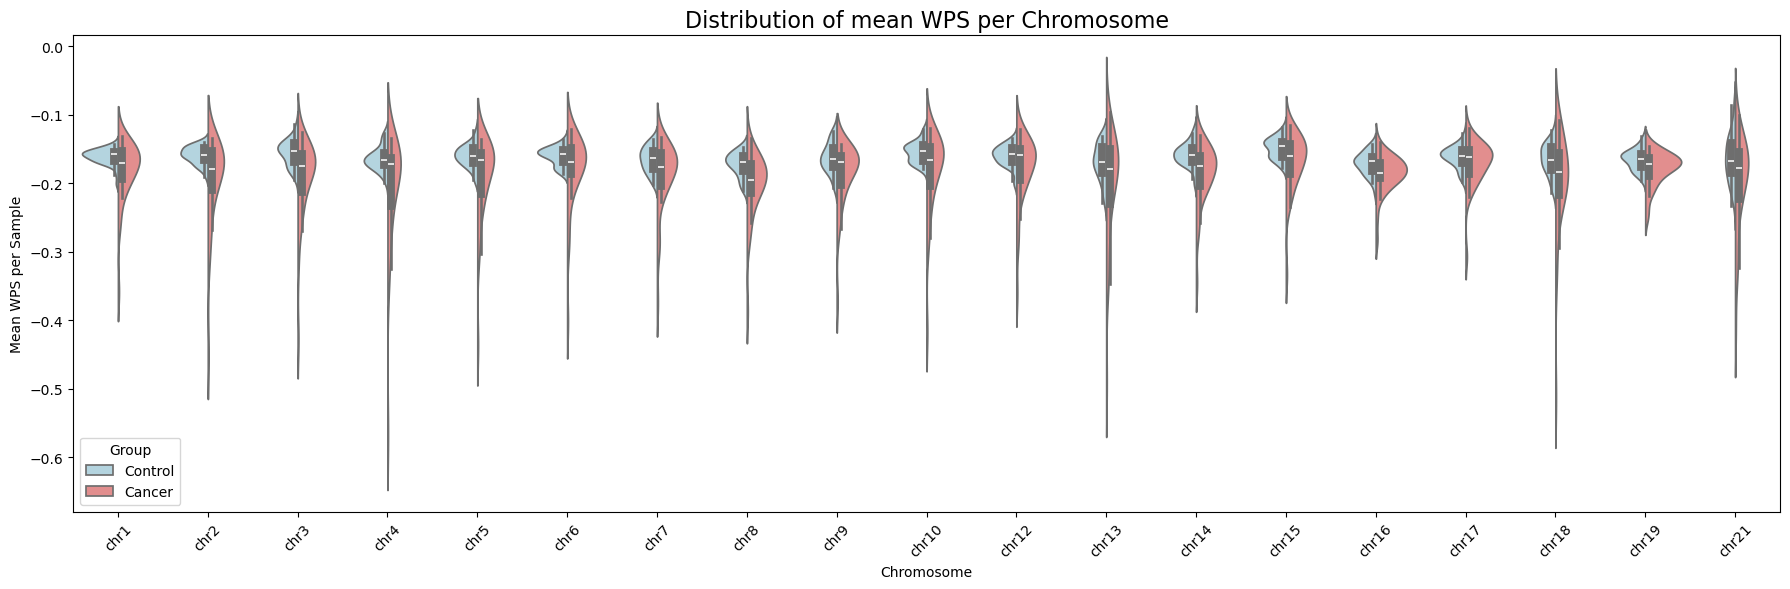

In [64]:
# 2. Violin Plot for chromosome wide analysis

all_chrom_means = []
for chrom in chromosomes:
    chrom_means = (
        combined_df[combined_df['chrom'] == chrom]
        .groupby(['sample', 'group'])['wps_value']
        .mean()
        .reset_index(name='mean_wps_per_sample')
    )
    chrom_means['chrom'] = chrom
    all_chrom_means.append(chrom_means)

all_chrom_means_df = pd.concat(all_chrom_means, ignore_index=True)

chrom_order = sorted(
    all_chrom_means_df['chrom'].unique(),
    key=lambda x: int(x.replace('chr', ''))
)

plt.figure(figsize=(18, 6))
sns.violinplot(
    data=all_chrom_means_df, 
    x='chrom', y='mean_wps_per_sample', hue='group',
    split=True,
    inner='box',
    order=chrom_order,
    palette={"Cancer":"lightcoral", "Control":"lightblue"}
)
plt.title("Distribution of mean WPS per Chromosome", fontsize=16)
plt.xlabel("Chromosome")
plt.ylabel("Mean WPS per Sample")
plt.xticks(rotation=45)
plt.legend(title='Group')
plt.tight_layout()
plt.show()


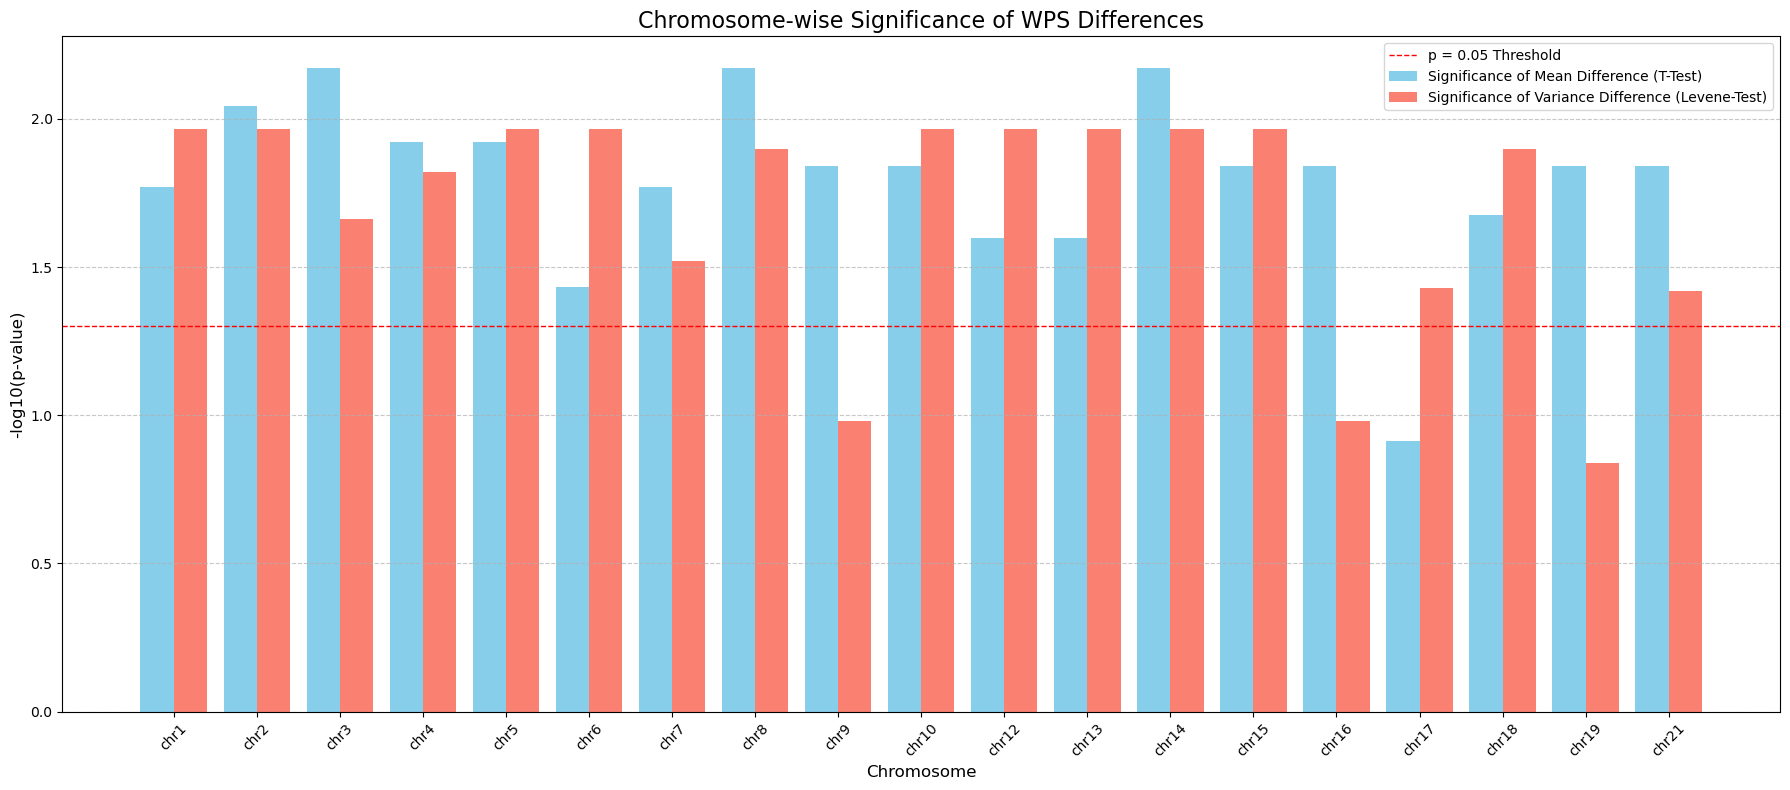

In [65]:
# 2. Chromosome-wise plotting of WPS

stats_results_chrom_df['-log10_p_ttest'] = -np.log10(stats_results_chrom_df['q_value_ttest'] + 1e-300) 
stats_results_chrom_df['-log10_p_levene'] = -np.log10(stats_results_chrom_df['q_value_levene'] + 1e-300)

plt.figure(figsize=(18, 8))
x_pos = np.arange(len(stats_results_chrom_df['chromosome']))
plt.bar(x_pos - 0.2, stats_results_chrom_df['-log10_p_ttest'], width=0.4,
        color='skyblue', label='Significance of Mean Difference (T-Test)')
plt.bar(x_pos + 0.2, stats_results_chrom_df['-log10_p_levene'], width=0.4,
        color='salmon', label='Significance of Variance Difference (Levene-Test)')
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', linewidth=1, label='p = 0.05 Threshold')

plt.title('Chromosome-wise Significance of WPS Differences', fontsize=16)
plt.xlabel('Chromosome', fontsize=12)
plt.ylabel('-log10(p-value)', fontsize=12)
plt.xticks(ticks=x_pos, labels=stats_results_chrom_df['chromosome'], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Tabelle mit Mittelwert und Varianz pro Chromosom und pro Probe:
    sample    group  chrom  mean_wps_per_chrom  variance_wps_per_chrom
0  EE87935  Control   chr1           -0.178267                0.016627
1  EE87935  Control  chr10           -0.136007                0.008493
2  EE87935  Control  chr12           -0.190525                0.008281
3  EE87935  Control  chr13           -0.158744                0.027471
4  EE87935  Control  chr14           -0.189149                0.009019


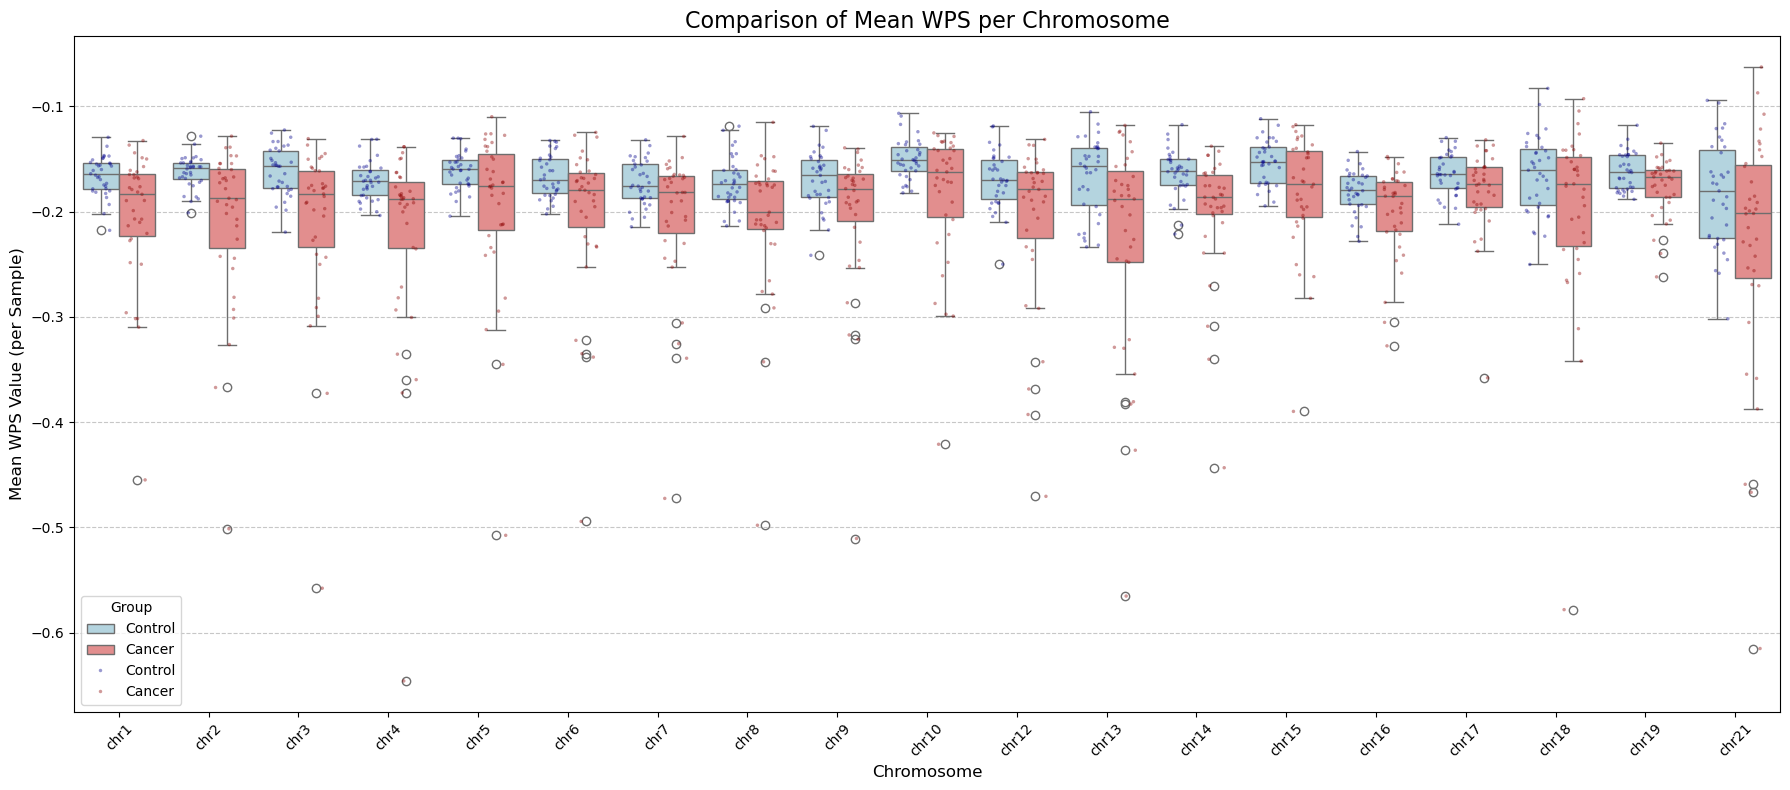

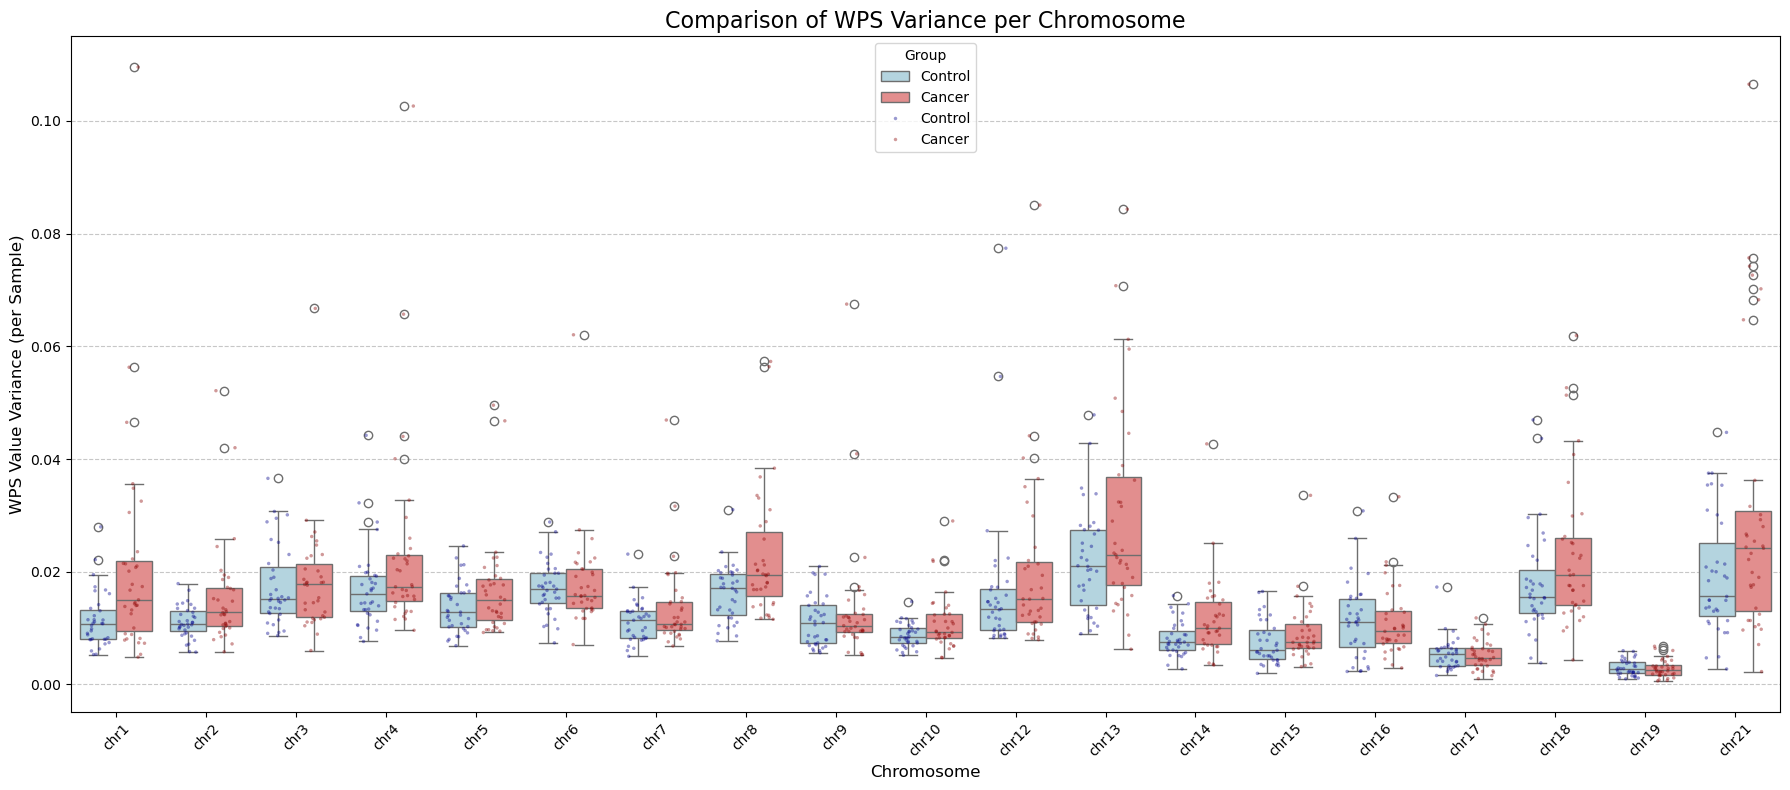

In [66]:
# 2. Plotting mean /variance of WPS per chromosome

chrom_stats_df = binned_combined_df.groupby(['sample', 'group', 'chrom'])['wps_value'].agg(['mean', 'var']).reset_index()

# Benenne die Spalten für bessere Lesbarkeit um
chrom_stats_df = chrom_stats_df.rename(columns={'mean': 'mean_wps_per_chrom', 'var': 'variance_wps_per_chrom'})

print("Tabelle mit Mittelwert und Varianz pro Chromosom und pro Probe:")
print(chrom_stats_df.head())
# Sortiere die Chromosomen in natürlicher Reihenfolge für den Plot
chrom_order = sorted(chrom_stats_df['chrom'].unique(), key=lambda x: int(x.replace('chr', '').replace('X', '23').replace('Y', '24')))

# Mean WPS Plot
plt.figure(figsize=(18, 8))

sns.boxplot(data=chrom_stats_df, x='chrom', y='mean_wps_per_chrom', hue='group', order=chrom_order,
            palette={"Cancer": "lightcoral", "Control": "lightblue"})
sns.stripplot(
    data=chrom_stats_df,
    x='chrom', y='mean_wps_per_chrom', hue='group',
    order=chrom_order, dodge=True, jitter=0.25,   # jitter für Streuung
    alpha=0.4, size=2.5, palette={"Cancer": "darkred", "Control": "darkblue"}
)
plt.title('Comparison of Mean WPS per Chromosome', fontsize=16)
plt.xlabel('Chromosome', fontsize=12)
plt.ylabel('Mean WPS Value (per Sample)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Group')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Varianz Plot
plt.figure(figsize=(18, 8))

sns.boxplot(data=chrom_stats_df, x='chrom', y='variance_wps_per_chrom', hue='group', order=chrom_order,
            palette={"Cancer": "lightcoral", "Control": "lightblue"})
sns.stripplot(
    data=chrom_stats_df,
    x='chrom', y='variance_wps_per_chrom', hue='group',
    order=chrom_order, dodge=True, jitter=0.25,  
    alpha=0.4, size=2.5, palette={"Cancer": "darkred", "Control": "darkblue"}
)
plt.title('Comparison of WPS Variance per Chromosome', fontsize=16)
plt.xlabel('Chromosome', fontsize=12)
plt.ylabel('WPS Value Variance (per Sample)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Group')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
cancer_samples_a = [
    "EE88290", "EE88291", "EE88292", "EE88293", "EE88294", "EE88295"  # First 6 cancer samples
]

control_samples_a = [
    "EE87935", "EE87936", "EE87937", "EE87938", "EE87939", 
    "EE87940", "EE87941", "EE87942", "EE87943"  # First 9 control samples
]

all_samples_a = cancer_samples_a + control_samples_a
print(f"Dataset A: {len(all_samples_a)} samples ({len(cancer_samples_a)} cancer, {len(control_samples_a)} control)")

def create_pca_dataset_a():
    """Create PCA analysis for Dataset A showing no clear group separation"""
    
    # Load the chromosome statistics data
   # if os.path.exists("dataframes_notebook/chrom_stats_df.parquet"):
   #     chrom_stats_df = pd.read_parquet("dataframes_notebook/chrom_stats_df.parquet")
   # else:
   #     print("Error: chrom_stats_df.parquet not found. Run main analysis first.")
    #    return
    
    # Filter for Dataset A samples only
    dataset_a_df = chrom_stats_df[chrom_stats_df['sample'].isin(all_samples_a)].copy()
    
    print(f"Found {len(dataset_a_df['sample'].unique())} samples in Dataset A")
    print("Samples:", sorted(dataset_a_df['sample'].unique()))
    
    # Create feature matrix for PCA (mean WPS per chromosome)
    feature_matrix_pca = dataset_a_df.pivot(
        index='sample', 
        columns='chrom', 
        values='mean_wps_per_chrom'
    )
    
    # Fill any NaN values
    feature_matrix_pca = feature_matrix_pca.fillna(feature_matrix_pca.mean())
    
    print(f"Feature matrix shape: {feature_matrix_pca.shape}")
    print("Chromosomes included:", list(feature_matrix_pca.columns))
    
    # Standardize the features
    scaler = StandardScaler()
    feature_matrix_scaled = scaler.fit_transform(feature_matrix_pca)
    
    # Perform PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(feature_matrix_scaled)
    explained_variance = pca.explained_variance_ratio_ * 100
    
    # Create PCA DataFrame
    pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
    pca_df['sample'] = feature_matrix_pca.index
    
    # Add group labels
    pca_df['group'] = pca_df['sample'].apply(
        lambda x: 'Cancer' if x in cancer_samples_a else 'Control'
    )
    
    # Create the plot
    plt.figure(figsize=(8, 6))
    colors = {'Cancer': 'red', 'Control': 'blue'}
    
    for group in pca_df['group'].unique():
        subset = pca_df[pca_df['group'] == group]
        plt.scatter(
            subset['PC1'], subset['PC2'], 
            label=group, color=colors[group], 
            s=100, alpha=0.7, edgecolors='black', linewidth=0.5
        )
    
    plt.xlabel(f'PC1 ({explained_variance[0]:.1f}% variance)')
    plt.ylabel(f'PC2 ({explained_variance[1]:.1f}% variance)')
    plt.title('PCA Analysis - Dataset A (15 samples)\nNo Clear Group Separation', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    
    # Add annotation about the findings
    plt.figtext(0.5, 0.02, 
                'Small sample size (n=15) shows overlapping groups, supporting need for larger cohort',
                ha='center', fontsize=10, style='italic')
    
    plt.tight_layout()
    plt.savefig('plots/pca_dataset_a_figure3.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\n=== PCA Results Summary ===")
    print(f"PC1 explains {explained_variance[0]:.1f}% of variance")
    print(f"PC2 explains {explained_variance[1]:.1f}% of variance") 
    print(f"Total variance explained: {sum(explained_variance):.1f}%")
    
    print("\n=== Group Statistics ===")
    for group in ['Cancer', 'Control']:
        group_data = pca_df[pca_df['group'] == group]
        print(f"{group} (n={len(group_data)}):")
        print(f"  PC1 mean: {group_data['PC1'].mean():.3f} ± {group_data['PC1'].std():.3f}")
        print(f"  PC2 mean: {group_data['PC2'].mean():.3f} ± {group_data['PC2'].std():.3f}")
    
    # Calculate overlap/separation metrics
    cancer_center = pca_df[pca_df['group'] == 'Cancer'][['PC1', 'PC2']].mean()
    control_center = pca_df[pca_df['group'] == 'Control'][['PC1', 'PC2']].mean()
    distance = np.sqrt(((cancer_center - control_center)**2).sum())
    
    print(f"\nDistance between group centers: {distance:.3f}")
    print("Interpretation: Small distance indicates poor group separation")
    
    return pca_df, explained_variance

if __name__ == "__main__":
    # Create plots directory if needed
    os.makedirs('plots', exist_ok=True)
    
    # Run the PCA analysis
    pca_results = create_pca_dataset_a()
    
    print("\n=== Analysis Complete ===")
    print("Figure 3 saved as: plots/pca_dataset_a_figure3.png")
    print("\nConclusion: The PCA shows overlapping groups with no clear separation,")
    print("supporting the need for a larger sample size (Dataset B with 70 samples).")

In [67]:
chrom_stats_df.to_parquet("dataframes_notebook/chrom_stats_df.parquet", index=False)

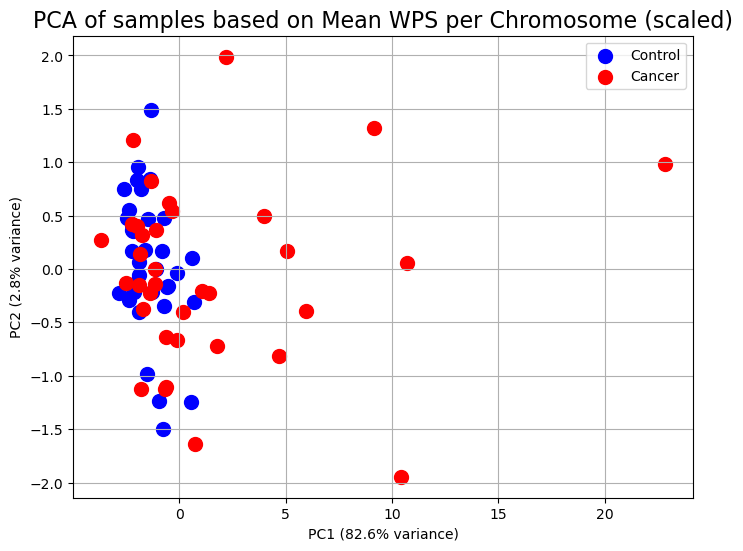

In [68]:
# 2. PCA auf chromosome mean WPS
feature_matrix_pca = chrom_stats_df.pivot(index='sample', columns='chrom', values='mean_wps_per_chrom')

# Skalierung hinzufügen
scaler = StandardScaler()
feature_matrix_scaled = scaler.fit_transform(feature_matrix_pca)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(feature_matrix_scaled)
explained_variance = pca.explained_variance_ratio_ * 100

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['sample'] = feature_matrix_pca.index
group_map = chrom_stats_df[['sample', 'group']].drop_duplicates().set_index('sample')['group']
pca_df['group'] = pca_df['sample'].map(group_map)

plt.figure(figsize=(8,6))
colors = {'Cancer':'red', 'Control':'blue'}
for g in pca_df['group'].unique():
    subset = pca_df[pca_df['group']==g]
    plt.scatter(subset['PC1'], subset['PC2'], label=g, color=colors[g], s=100)
plt.xlabel(f'PC1 ({explained_variance[0]:.1f}% variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.1f}% variance)')
plt.title('PCA of samples based on Mean WPS per Chromosome (scaled)', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

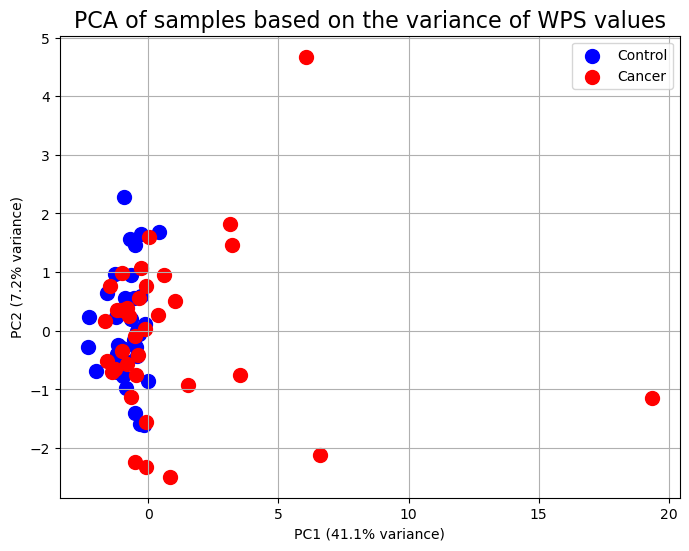

In [69]:
# 2. PCA auf chromosome varinace WPS
feature_matrix_pca = chrom_stats_df.pivot(index='sample', columns='chrom', values='variance_wps_per_chrom')

# Skalierung hinzufügen
scaler = StandardScaler()
feature_matrix_scaled = scaler.fit_transform(feature_matrix_pca)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(feature_matrix_scaled)
explained_variance = pca.explained_variance_ratio_ * 100

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['sample'] = feature_matrix_pca.index
group_map = chrom_stats_df[['sample', 'group']].drop_duplicates().set_index('sample')['group']
pca_df['group'] = pca_df['sample'].map(group_map)

plt.figure(figsize=(8,6))
colors = {'Cancer':'red', 'Control':'blue'}
for g in pca_df['group'].unique():
    subset = pca_df[pca_df['group']==g]
    plt.scatter(subset['PC1'], subset['PC2'], label=g, color=colors[g], s=100)
plt.xlabel(f'PC1 ({explained_variance[0]:.1f}% variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.1f}% variance)')
plt.title('PCA of samples based on the variance of WPS values', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

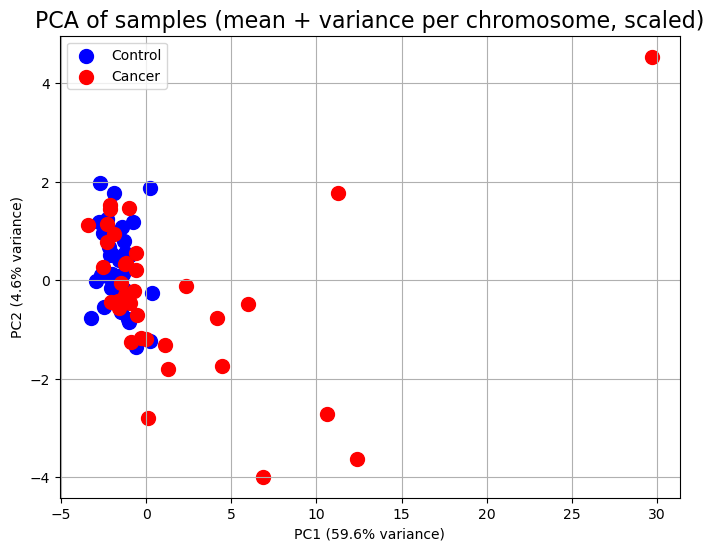

In [70]:
# 2. PCA mit mean und varianz pro chromosom

mean_matrix = chrom_stats_df.pivot(index='sample', columns='chrom', values='mean_wps_per_chrom')
var_matrix = chrom_stats_df.pivot(index='sample', columns='chrom', values='variance_wps_per_chrom')

feature_matrix = pd.concat([mean_matrix, var_matrix], axis=1)

scaler = StandardScaler()
feature_matrix_scaled = scaler.fit_transform(feature_matrix)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(feature_matrix_scaled)
explained_variance = pca.explained_variance_ratio_ * 100

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['sample'] = feature_matrix.index
group_map = chrom_stats_df[['sample', 'group']].drop_duplicates().set_index('sample')['group']
pca_df['group'] = pca_df['sample'].map(group_map)

plt.figure(figsize=(8,6))
colors = {'Cancer':'red', 'Control':'blue'}
for g in pca_df['group'].unique():
    subset = pca_df[pca_df['group']==g]
    plt.scatter(subset['PC1'], subset['PC2'], label=g, color=colors[g], s=100)
plt.xlabel(f'PC1 ({explained_variance[0]:.1f}% variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.1f}% variance)')
plt.title('PCA of samples (mean + variance per chromosome, scaled)', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

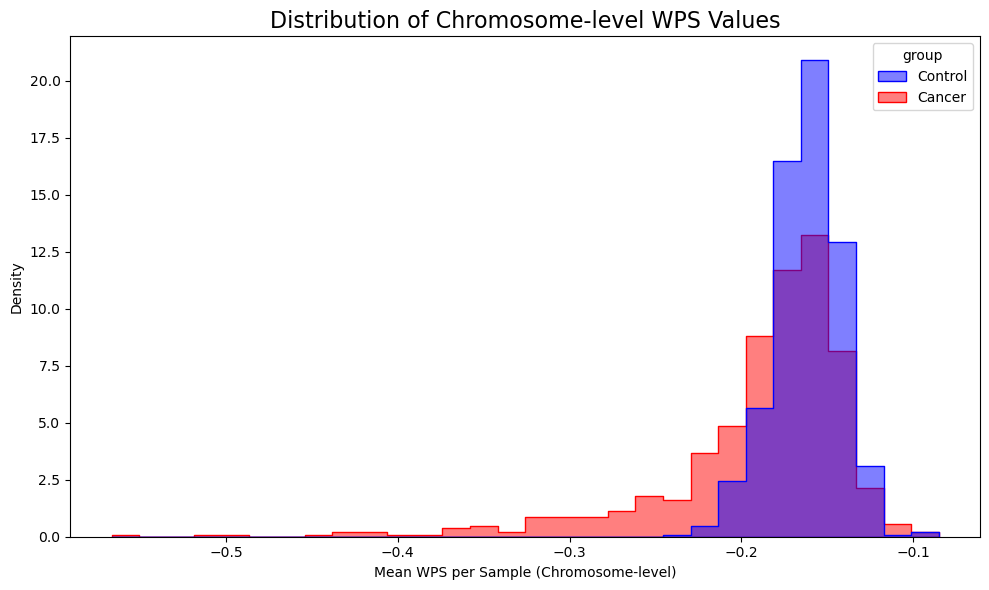

In [71]:
# 2. Plot für Verteilung der WPS Werte auf Chromosomenebene
plt.figure(figsize=(10,6))
sns.histplot(
    data=all_chrom_means_df,
    x='mean_wps_per_sample',
    hue='group',
    bins=30,
    element='step',
    stat='density',
    common_norm=False,
    palette={"Cancer": "red", "Control": "blue"},
    alpha=0.5
)

plt.title("Distribution of Chromosome-level WPS Values", fontsize=16)
plt.xlabel("Mean WPS per Sample (Chromosome-level)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

In [72]:
# Feature Matrix for LR rows:sample columns:bins+groups 

binned_combined_df['feature_name'] = binned_combined_df['chrom'] + '_bin_' + binned_combined_df['bin'].astype(str)
feature_matrix = binned_combined_df.pivot(index='sample', columns='feature_name', values='wps_value')
group_info = binned_combined_df[['sample', 'group']].drop_duplicates().set_index('sample')
final_feature_matrix = feature_matrix.join(group_info)
final_feature_matrix = final_feature_matrix.fillna(0)
print(final_feature_matrix.head())

         chr10_bin_0  chr10_bin_1  chr10_bin_10  chr10_bin_11  chr10_bin_12  \
sample                                                                        
EE87935    -0.293724    -0.154054      0.099114     -0.188858     -0.318905   
EE87936    -0.222861    -0.085570     -0.211743     -0.159982     -0.006142   
EE87937    -0.151781    -0.253700     -0.212953     -0.251962     -0.144926   
EE87938    -0.197883    -0.166031     -0.064145     -0.210066     -0.026548   
EE87939    -0.202488    -0.247189      0.011074     -0.159954     -0.137317   

         chr10_bin_13  chr10_bin_14  chr10_bin_15  chr10_bin_16  chr10_bin_17  \
sample                                                                          
EE87935     -0.149995     -0.126403     -0.210443     -0.076872     -0.166336   
EE87936     -0.132513     -0.232108     -0.243438     -0.161031     -0.280486   
EE87937     -0.064997     -0.067352     -0.306005     -0.149243     -0.231651   
EE87938     -0.159504     -0.045493     -

In [73]:
final_feature_matrix.to_parquet("dataframes_notebook/final_feature_matrix.parquet", index=True)

In [74]:
# 1. Bin wide Analysis: Detailed stats per bin with means, effect size, t-test, Levene test, FDR correction

replace_zero_with_nan = False

feature_matrix_cancer = final_feature_matrix.loc[cancer_samples]
feature_matrix_healthy = final_feature_matrix.loc[control_samples]

results = []
feature_columns = [col for col in final_feature_matrix.columns if col not in ['group','sample']]

for feat in feature_columns:
    c_vals = feature_matrix_cancer[feat]
    h_vals = feature_matrix_healthy[feat]
    if replace_zero_with_nan:
        c_vals = c_vals.replace(0, np.nan)
        h_vals = h_vals.replace(0, np.nan)
    c_vals = c_vals.dropna()
    h_vals = h_vals.dropna()

    n_c = len(c_vals)
    n_h = len(h_vals)

    t_stat = np.nan
    p_t = np.nan
    lev_stat = np.nan
    p_lev = np.nan
    mean_c = np.nan
    mean_h = np.nan
    effect = np.nan


    if n_c > 0 and n_h > 0:
        t_stat, p_t = ttest_ind(c_vals, h_vals, equal_var=False, nan_policy='omit')
        lev_stat, p_lev = levene(c_vals, h_vals, center='median')
        mean_c = c_vals.mean()
        mean_h = h_vals.mean()
        effect = mean_c - mean_h

    results.append({
        'bin': feat,
        'n_cancer': n_c,
        'n_control': n_h,
        'mean_cancer': mean_c,
        'mean_control': mean_h,
        'effect_size': effect,
        't_statistic': t_stat,
        'p_value_ttest': p_t,
        'levene_statistic': lev_stat,
        'p_value_levene': p_lev
    })

bin_statistics_df = pd.DataFrame(results)

mask_t = bin_statistics_df['p_value_ttest'].notna()
if mask_t.any():
    rej_t, qvals_t, _, _ = multipletests(bin_statistics_df.loc[mask_t, 'p_value_ttest'], alpha=0.05, method='fdr_bh')
    bin_statistics_df.loc[mask_t, 'q_value_ttest'] = qvals_t
    bin_statistics_df.loc[mask_t, 'significant_fdr_ttest'] = rej_t
else:
    bin_statistics_df['q_value_ttest'] = np.nan
    bin_statistics_df['significant_fdr_ttest'] = False

mask_l = bin_statistics_df['p_value_levene'].notna()
if mask_l.any():
    rej_l, qvals_l, _, _ = multipletests(bin_statistics_df.loc[mask_l, 'p_value_levene'], alpha=0.05, method='fdr_bh')
    bin_statistics_df.loc[mask_l, 'q_value_levene'] = qvals_l
    bin_statistics_df.loc[mask_l, 'significant_fdr_levene'] = rej_l
else:
    bin_statistics_df['q_value_levene'] = np.nan
    bin_statistics_df['significant_fdr_levene'] = False

bin_statistics_df = bin_statistics_df.sort_values('p_value_ttest', na_position='last').reset_index(drop=True)


#print(f"# bins significant by Levene after FDR: {bin_statistics_df['significant_fdr_levene'].sum()}")


In [75]:
#bin_statistics_df.sort_values('p_value_levene', na_position='last').head(10)[['bin','levene_statistic','p_value_levene','q_value_levene','significant_fdr_levene','n_cancer','n_control']])

#print(f"\n# bins with nominal t-test p (not NaN): {mask_t.sum()}")
#print(f"# bins significant by t-test after FDR: {bin_statistics_df['significant_fdr_ttest'].sum()}")
print("sgnificant after welch:", len(bin_statistics_df[bin_statistics_df['p_value_ttest']<0.05]))
print("sgnificant after levene:", len(bin_statistics_df[bin_statistics_df['p_value_levene']<0.05]))
print("sgnificant after welch fdr:", len(bin_statistics_df[bin_statistics_df['q_value_ttest']<0.05]))
print("sgnificant after levene fdr:", len(bin_statistics_df[bin_statistics_df['q_value_levene']<0.05]))



sgnificant after welch: 33
sgnificant after levene: 36
sgnificant after welch fdr: 0
sgnificant after levene fdr: 0


In [76]:
bin_statistics_df.to_parquet(f"dataframes_notebook/bin_statistics.parquet_{bin_size}", index=False)

In [77]:
print(bin_statistics_df.head())

            bin  n_cancer  n_control  mean_cancer  mean_control  effect_size  \
0   chr1_bin_36         6          9    -0.421738     -0.106358    -0.315380   
1   chr9_bin_21         6          9    -0.270966     -0.148953    -0.122013   
2   chr14_bin_4         6          9    -0.176116     -0.129912    -0.046205   
3   chr13_bin_6         6          9    -0.194018     -0.049074    -0.144943   
4  chr13_bin_15         6          9    -0.455613     -0.071119    -0.384494   

   t_statistic  p_value_ttest  levene_statistic  p_value_levene  \
0    -3.824692       0.002112          1.315881        0.272007   
1    -3.868824       0.002600          0.157161        0.698215   
2    -3.447406       0.005248          3.365394        0.089561   
3    -3.215841       0.009713          0.003800        0.951783   
4    -3.032712       0.013993          0.226819        0.641797   

   q_value_ttest significant_fdr_ttest  q_value_levene significant_fdr_levene  
0       0.551461                 Fal

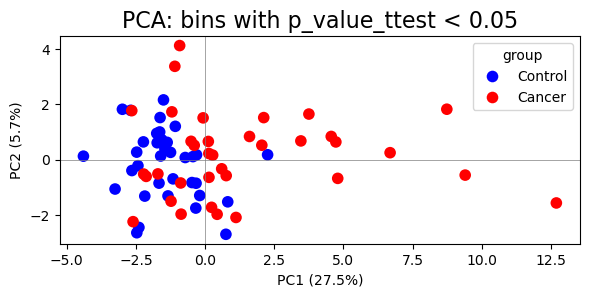

No bins passed q_value_ttest < 0.05. Using top 20 bins by q_value_ttest as fallback.


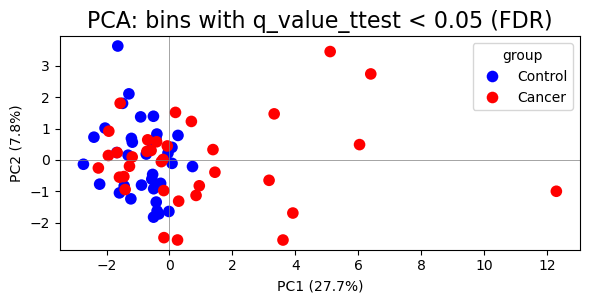

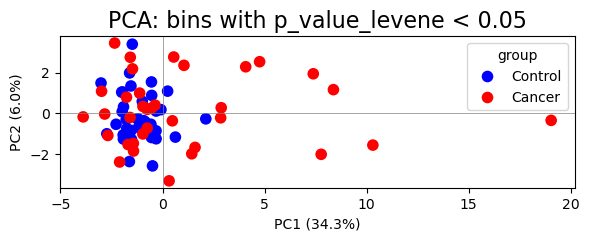

No bins passed q_value_levene < 0.05. Using top 20 bins by q_value_levene as fallback.


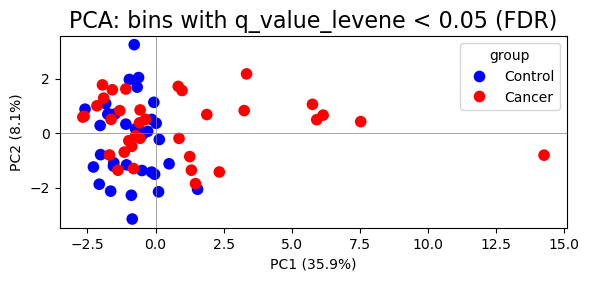

{'pca_df':               PC1       PC2    group
 sample                              
 EE87935 -0.496038 -0.081000  Control
 EE87936 -0.033595 -1.513150  Control
 EE87937  0.498077 -1.129645  Control
 EE87938  0.023665  0.357694  Control
 EE87939 -0.434510  0.000971  Control
 ...           ...       ...      ...
 EE88320 -1.946347  1.766119   Cancer
 EE88321 -1.379389 -1.365448   Cancer
 EE88322 -0.729939 -0.098948   Cancer
 EE88323  2.340720 -1.429281   Cancer
 EE88324 -0.806529 -1.304123   Cancer
 
 [70 rows x 3 columns],
 'evr': array([0.3591324 , 0.08087264]),
 'selected_bins': ['chr2_bin_15',
  'chr8_bin_18',
  'chr14_bin_10',
  'chr19_bin_2',
  'chr7_bin_20',
  'chr21_bin_3',
  'chr6_bin_16',
  'chr4_bin_3',
  'chr14_bin_6',
  'chr12_bin_3',
  'chr1_bin_3',
  'chr17_bin_14',
  'chr16_bin_2',
  'chr10_bin_9',
  'chr6_bin_19',
  'chr19_bin_1',
  'chr18_bin_12',
  'chr1_bin_10',
  'chr15_bin_5',
  'chr5_bin_27']}

In [78]:
# PCA Plot vor und nach signifikanten Bins (p_value_levene < 0.05) and (p_value_ttest < 0.05)

def plot_pca_for_bins(feature_matrix, bin_statistics_df, stat_col, thresh=0.05,
                        title=None, palette=None, s=70, fallback_top_n=0):

    if palette is None:
        palette = {"Cancer": "red", "Control": "blue"}

    if 'group' not in feature_matrix.columns:
        raise ValueError("feature_matrix must contain a 'group' column with values 'Cancer'/'Control'.")

    if 'bin' not in bin_statistics_df.columns or stat_col not in bin_statistics_df.columns:
        raise ValueError(f"bin_statistics_df must contain 'bin' and '{stat_col}' columns.")

    available_bins = set(feature_matrix.columns) - {'group', 'sample'}
    selected_bins = bin_statistics_df.loc[bin_statistics_df[stat_col] < thresh, 'bin'].tolist()
    selected_bins = [b for b in selected_bins if b in available_bins]

    if len(selected_bins) == 0 and fallback_top_n > 0:
        print(f"No bins passed {stat_col} < {thresh}. Using top {fallback_top_n} bins by {stat_col} as fallback.")
        ranked = bin_statistics_df.sort_values(stat_col).loc[bin_statistics_df['bin'].isin(available_bins), 'bin']
        selected_bins = ranked.head(fallback_top_n).tolist()

    if len(selected_bins) == 0:
        print(f"No bins available for {stat_col} < {thresh} (and no fallback). Skipping PCA.")
        return None

    X = feature_matrix[selected_bins].copy()
    y = feature_matrix['group'].copy()

    X_scaled = StandardScaler().fit_transform(X.values)

    pca = PCA(n_components=2)
    pcs = pca.fit_transform(X_scaled)
    evr = pca.explained_variance_ratio_

    pca_df = pd.DataFrame(pcs, columns=['PC1', 'PC2'], index=feature_matrix.index)
    pca_df['group'] = y.values

    plt.figure(figsize=(6,5))
    sns.scatterplot(
        data=pca_df, x='PC1', y='PC2', hue='group',
        palette=palette, s=s, edgecolor='none'
    )
    plt.axhline(0, color='grey', linewidth=0.5)
    plt.axvline(0, color='grey', linewidth=0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel(f"PC1 ({evr[0]*100:.1f}%)")
    plt.ylabel(f"PC2 ({evr[1]*100:.1f}%)")
    if title is None:
        title = f"PCA — {stat_col} < {thresh} — n_bins={len(selected_bins)}"
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

    return {'pca_df': pca_df, 'evr': evr, 'selected_bins': selected_bins}

# T-test: nominal p
plot_pca_for_bins(final_feature_matrix, bin_statistics_df, stat_col="p_value_ttest", thresh=0.05,
title="PCA: bins with p_value_ttest < 0.05", fallback_top_n=0)

# T-test: after FDR (q)
plot_pca_for_bins(final_feature_matrix, bin_statistics_df, stat_col="q_value_ttest", thresh=0.05,
title="PCA: bins with q_value_ttest < 0.05 (FDR)", fallback_top_n=20)

# Levene: nominal p
plot_pca_for_bins(final_feature_matrix, bin_statistics_df, stat_col="p_value_levene", thresh=0.05,
title="PCA: bins with p_value_levene < 0.05", fallback_top_n=0)

# Levene: after FDR (q)
plot_pca_for_bins(final_feature_matrix, bin_statistics_df, stat_col="q_value_levene", thresh=0.05,
title="PCA: bins with q_value_levene < 0.05 (FDR)", fallback_top_n=20)

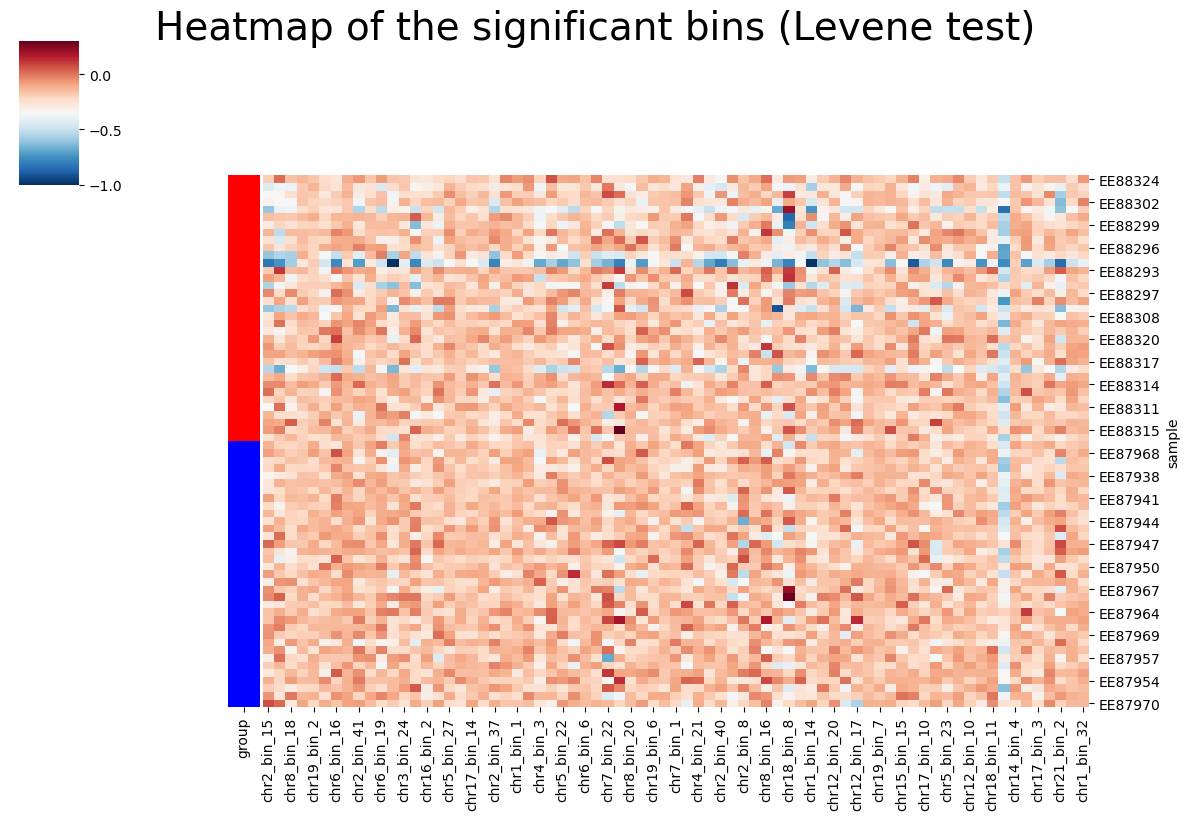

In [79]:
# 1. Bin wide Analysis: plotting top 20 significant bins by levene test

top20_df_levene = bin_statistics_df.sort_values('p_value_levene', na_position='last').head(73)[
    ['bin','levene_statistic','p_value_levene','q_value_levene','significant_fdr_levene','n_cancer','n_control']
]

cmap = "RdBu_r"
figsize = (12,8)

selected_bins = top20_df_levene['bin'].tolist()

sorted_df = final_feature_matrix.sort_values('group')
heat_data = sorted_df.loc[:, selected_bins]
sample_groups = sorted_df['group']

group_colors = sample_groups.map({'Cancer': 'red', 'Control': 'blue'})

sns.clustermap(
    heat_data,
    cmap=cmap,
    row_colors=group_colors,
    figsize=(12,8),
    col_cluster=False,
    row_cluster=False
)
plt.suptitle("Heatmap of the significant bins (Levene test)", y=1.02, fontsize=28)
plt.show()


In [80]:
print(bin_statistics_df.head())

            bin  n_cancer  n_control  mean_cancer  mean_control  effect_size  \
0   chr1_bin_36         6          9    -0.421738     -0.106358    -0.315380   
1   chr9_bin_21         6          9    -0.270966     -0.148953    -0.122013   
2   chr14_bin_4         6          9    -0.176116     -0.129912    -0.046205   
3   chr13_bin_6         6          9    -0.194018     -0.049074    -0.144943   
4  chr13_bin_15         6          9    -0.455613     -0.071119    -0.384494   

   t_statistic  p_value_ttest  levene_statistic  p_value_levene  \
0    -3.824692       0.002112          1.315881        0.272007   
1    -3.868824       0.002600          0.157161        0.698215   
2    -3.447406       0.005248          3.365394        0.089561   
3    -3.215841       0.009713          0.003800        0.951783   
4    -3.032712       0.013993          0.226819        0.641797   

   q_value_ttest significant_fdr_ttest  q_value_levene significant_fdr_levene  
0       0.551461                 Fal

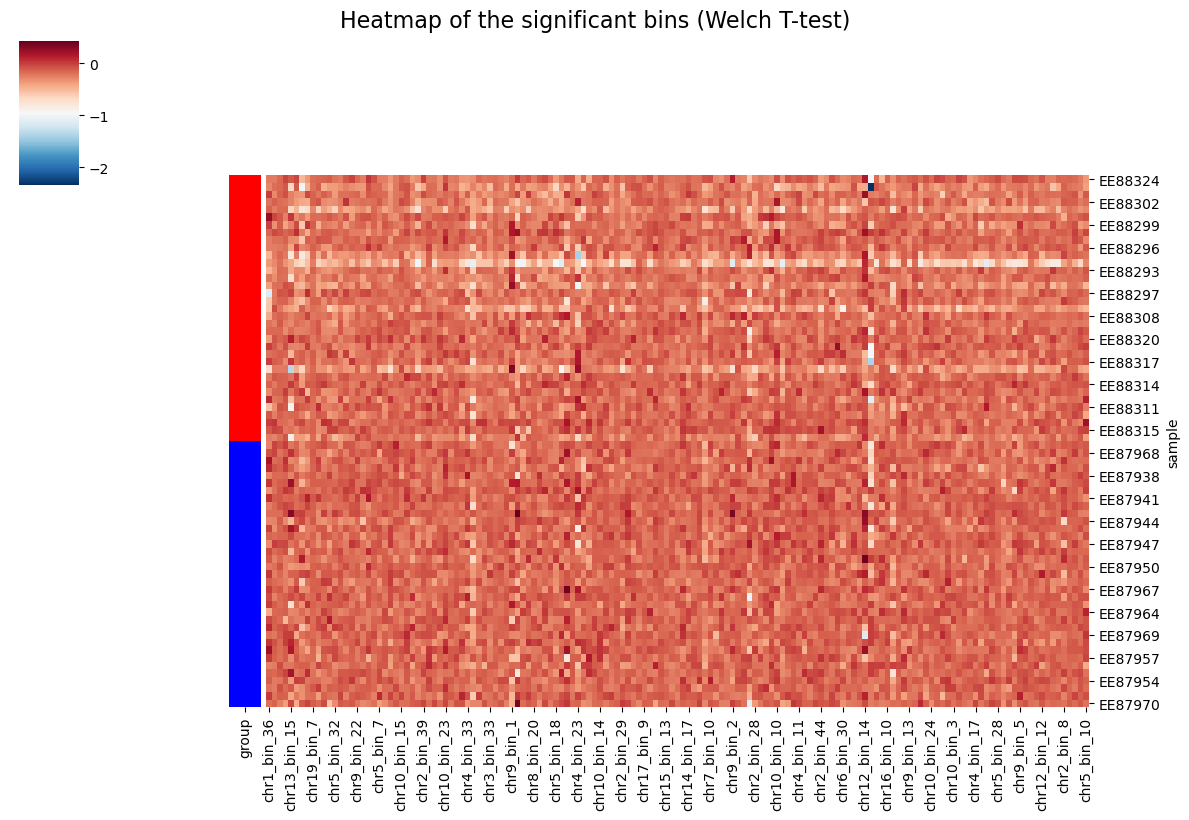

In [81]:
# 1. Bin wide Analysis: plotting top 20 significant bins by welch test

top20_df_ttest = bin_statistics_df.sort_values('p_value_ttest', na_position='last').head(149)[
    ['bin','t_statistic','p_value_ttest','q_value_ttest','significant_fdr_ttest','n_cancer','n_control']
]

cmap = "RdBu_r"
figsize = (12,8)

selected_bins = top20_df_ttest['bin'].tolist()

sorted_df = final_feature_matrix.sort_values('group')
heat_data = sorted_df.loc[:, selected_bins]
sample_groups = sorted_df['group']
group_colors = sample_groups.map({'Cancer': 'red', 'Control': 'blue'})
if not bin_statistics_df['significant_fdr_ttest'].fillna(False).empty and \
   bin_statistics_df['significant_fdr_ttest'].fillna(False).any():    
    col_colors = pd.Series(['green' if bin_name in bin_statistics_df[bin_statistics_df['significant_fdr_ttest']]['bin'].values else 'black'
                            for bin_name in selected_bins],
                            index=selected_bins, name='FDR significant')

    sns.clustermap(
        heat_data,
        cmap=cmap,
        row_colors=group_colors,
        col_colors=col_colors,
        figsize=(12,8),
        col_cluster=False,
        row_cluster=False
    )
    plt.suptitle("Heatmap of the significant bins (Welch T-test)", y=1.02, fontsize=16)
    plt.show()
else:
    sns.clustermap(
    heat_data,
    cmap=cmap,
    row_colors=group_colors,
    figsize=(12,8),
    col_cluster=False,
    row_cluster=False
    )
    plt.suptitle("Heatmap of the significant bins (Welch T-test)", y=1.02, fontsize=16)
    plt.show()

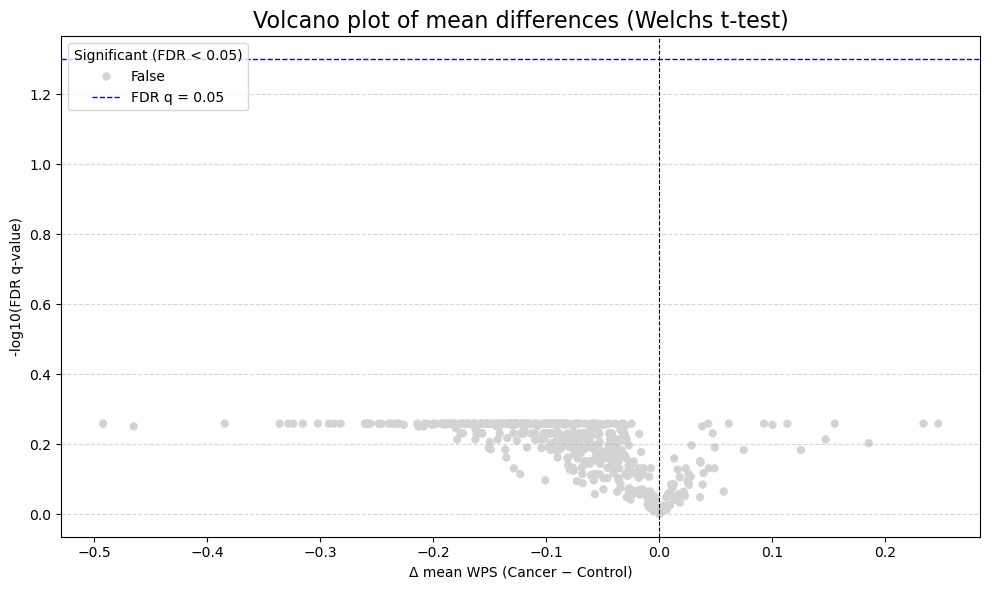

In [82]:
#1. Bin wide Analysis: Volcano Plot for mean differences (Welch-T-Test)

df = bin_statistics_df.copy() 
eps = 1e-12 
q_thresh = 0.05 

df['minus_log10_q_ttest'] = -np.log10(df['q_value_ttest'].clip(lower=eps))
df['significant_ttest'] = df['q_value_ttest'] < q_thresh


plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x='effect_size',
    y='minus_log10_q_ttest',
    hue='significant_ttest',
    palette={True:'red', False:'lightgray'},
    s=30,
    edgecolor=None
)

plt.axhline(-np.log10(q_thresh), color='blue', linestyle='--', linewidth=1, label=f'FDR q = {q_thresh}')
plt.axvline(0, color='black', linestyle='--', linewidth=0.8) 

plt.xlabel('Δ mean WPS (Cancer − Control)')
plt.ylabel('-log10(FDR q-value)')
plt.title('Volcano plot of mean differences (Welchs t-test)', fontsize=16)

plt.legend(title='Significant (FDR < 0.05)', loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


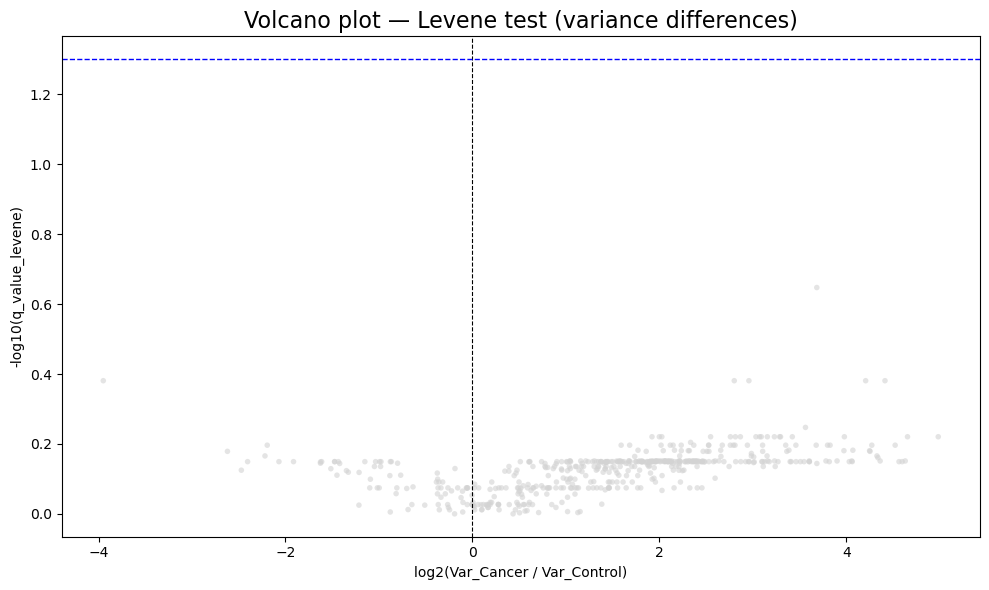

In [83]:
# 1. Bin wide Volcano plot for variance differences (Levene test)
use_q = True
q_thresh = 0.05
p_thresh = 0.05
top_annot = 15
eps = 1e-12
cmap = "Reds"

df = bin_statistics_df.copy()

var_c_list = []
var_h_list = []
for _, row in df.iterrows():
    feat = row['bin']
    if feat in final_feature_matrix.columns:
        cvals = final_feature_matrix.loc[cancer_samples, feat].replace(0, np.nan).dropna()
        hvals = final_feature_matrix.loc[control_samples, feat].replace(0, np.nan).dropna()
        var_c = cvals.var(ddof=1) if len(cvals) > 1 else np.nan
        var_h = hvals.var(ddof=1) if len(hvals) > 1 else np.nan
    else:
        var_c = np.nan
        var_h = np.nan
    var_c_list.append(var_c)
    var_h_list.append(var_h)

df['var_cancer'] = var_c_list
df['var_control'] = var_h_list

df['var_ratio_log2'] = np.log2((df['var_cancer'].fillna(eps) + eps) / (df['var_control'].fillna(eps) + eps))

if use_q and 'q_value_levene' in df.columns:
    sig_col = 'q_value_levene'
    thresh = q_thresh
    df['minus_log10'] = -np.log10(df['q_value_levene'].clip(lower=eps))
    df['sig_mask'] = df['q_value_levene'].notna() & (df['q_value_levene'] < thresh)
    y_label = '-log10(q_value_levene)'
else:
    sig_col = 'p_value_levene'
    thresh = p_thresh
    df['minus_log10'] = -np.log10(df['p_value_levene'].clip(lower=eps))
    df['sig_mask'] = df['p_value_levene'].notna() & (df['p_value_levene'] < thresh)
    y_label = '-log10(p_value_levene)'

plt.figure(figsize=(10,6))
plt.scatter(df['var_ratio_log2'], df['minus_log10'], color='lightgray', s=16, alpha=0.6, edgecolors='none')

sig_df = df[df['sig_mask'] & df['var_ratio_log2'].notna()]
if not sig_df.empty:
    sc = plt.scatter(sig_df['var_ratio_log2'], sig_df['minus_log10'],
                     c=sig_df[sig_col].fillna(1.0), cmap=cmap, s=30, edgecolors='k')
    cb = plt.colorbar(sc)
    cb.set_label(sig_col)

plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.axhline(-np.log10(thresh), color='blue', linestyle='--', linewidth=1, label=f'{sig_col}={thresh}')

plt.xlabel('log2(Var_Cancer / Var_Control)')
plt.ylabel(y_label)
plt.title('Volcano plot — Levene test (variance differences)', fontsize=16)

plt.tight_layout()
plt.show()


/home/lotta/miniconda3/envs/fragmentomics_analysis/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/lotta/miniconda3/envs/fragmentomics_analysis/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


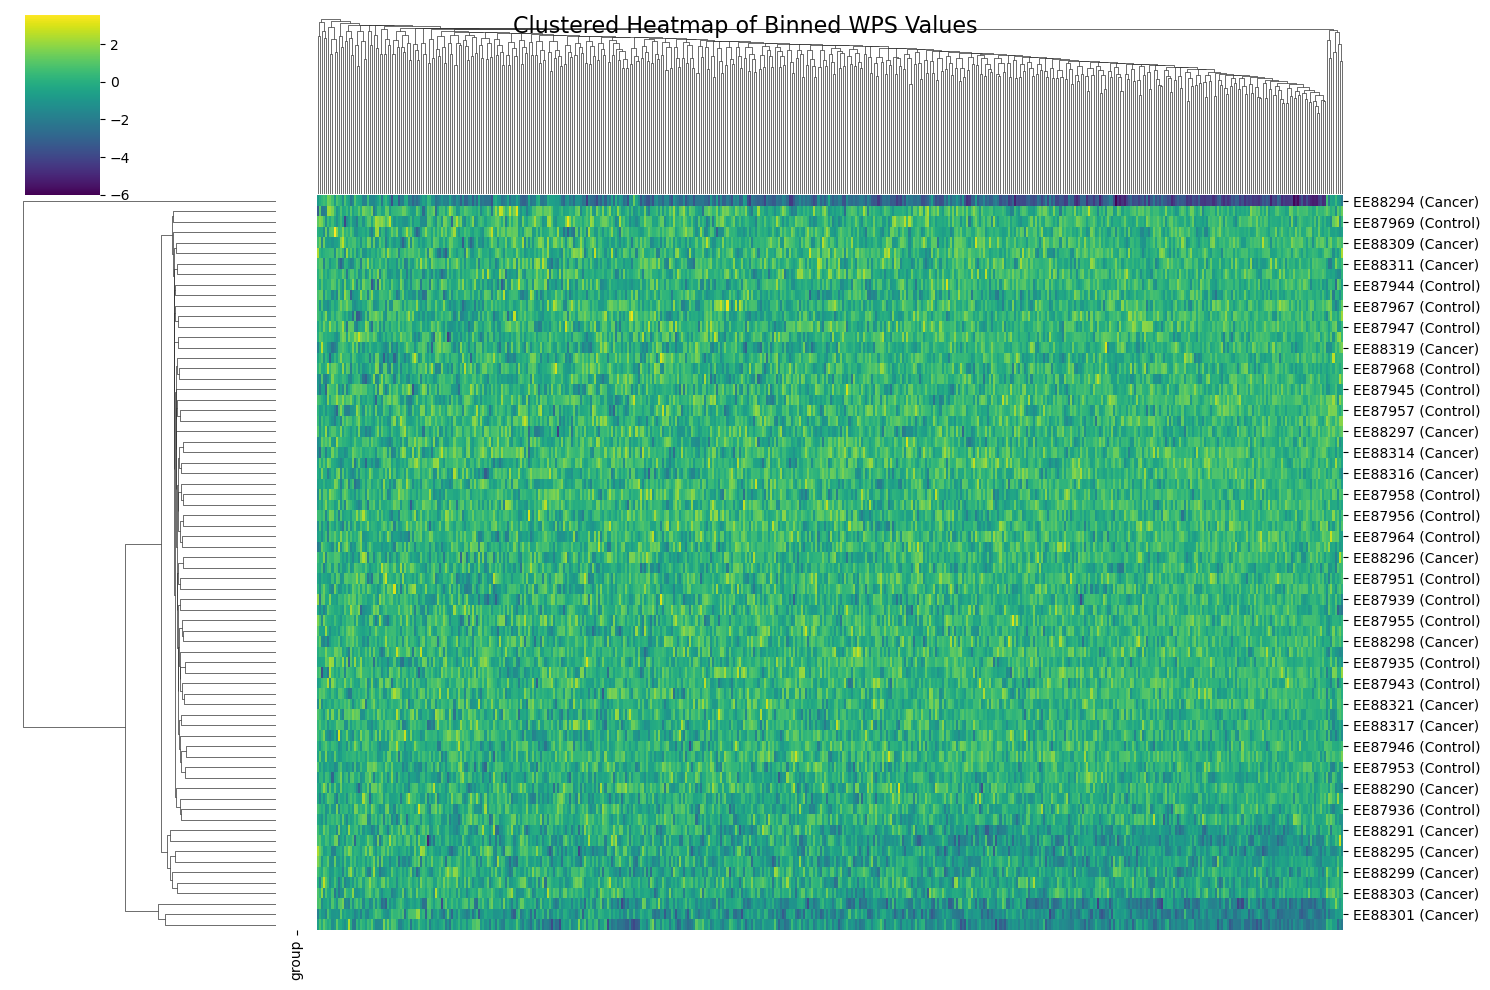

In [84]:
# Heatmap for every sample

X = final_feature_matrix.drop('group', axis=1)
y = final_feature_matrix['group']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

#Er berechnet den Mittelwert aller 16 WPS-Werte in dieser einen Spalte
#Er berechnet die Standardabweichung dieser 16 Werte
#Er transformiert jeden einzelnen Wert, indem er den Mittelwert abzieht und das Ergebnis durch die Standardabweichung teilt. Das Ergebnis ist der Z-Score


group_colors = y.map({'Cancer': 'red', 'Control': 'blue'})
row_colors = pd.DataFrame(group_colors)


X_scaled_df.index = [f"{idx} ({grp})" for idx, grp in zip(X.index, y)]

g = sns.clustermap(
    X_scaled_df, 
    row_colors=row_colors,
    cmap='viridis',
    figsize=(15, 10),
    xticklabels=False
)

g.fig.suptitle('Clustered Heatmap of Binned WPS Values', fontsize=16)
plt.show()
# Farbe in der Heatmap: wie abweichend der WPS-Wert einer bestimmten Probe in einem bestimmten Bin vom Durchschnitt aller Proben in demselben Bin ist.
# Geht auf die Bins ein nicht auf die Samples, sortiert nach Spalten (bins) nicht nach zeilen. ein wert in der zelle ist grün wenn er kaum vom 
# mittelwert des bins über alle proben abweicht





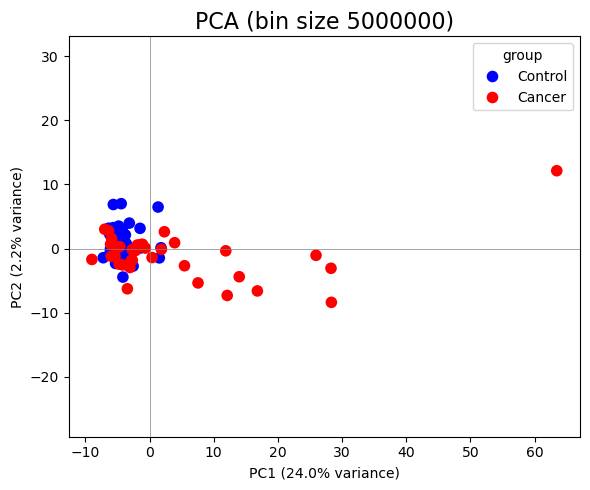

In [85]:
# pca mit allen bins


bin_columns = [c for c in final_feature_matrix.columns if "_bin_" in c]

X = final_feature_matrix[bin_columns]
y = final_feature_matrix['group']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(principal_components, columns=['PC1','PC2'])
pca_df['group'] = y.values
pca_df['sample'] = final_feature_matrix.index
explained_variance = pca.explained_variance_ratio_ * 100

plt.figure(figsize=(6, 5))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='group',
    palette={"Cancer": "red", "Control": "blue"},
    data=pca_df,
    s=70,
    edgecolor='none'
)

plt.axhline(0, color="grey", linewidth=0.5)
plt.axvline(0, color="grey", linewidth=0.5)

plt.axis('equal')

plt.title(f"PCA (bin size {bin_size})", fontsize=16)
plt.xlabel(f'PC1 ({explained_variance[0]:.1f}% variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.1f}% variance)')
plt.tight_layout()
plt.show()


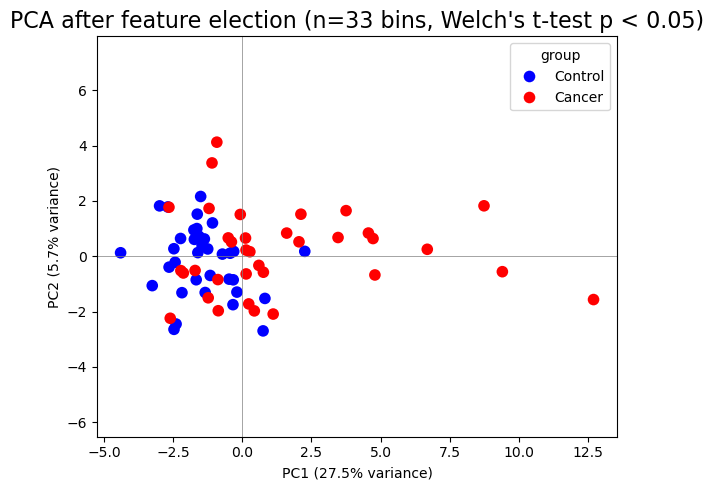

In [86]:
# PCA nur mit den signifikanten Bins (p_value_ttest < 0.05)
significant_bins = bin_statistics_df.query("p_value_ttest < 0.05")["bin"].tolist()

if len(significant_bins) == 0:
    print("⚠️ Keine signifikanten Bins gefunden!")
else:
    X = final_feature_matrix[significant_bins]
    y = final_feature_matrix["group"]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=2)
    pcs = pca.fit_transform(X_scaled)
    explained_variance = pca.explained_variance_ratio_ * 100

    pca_df = pd.DataFrame(pcs, columns=["PC1","PC2"])
    pca_df["group"] = y.values
    pca_df["sample"] = final_feature_matrix.index

    plt.figure(figsize=(6,5))
    sns.scatterplot(
        x="PC1", y="PC2", hue="group",
        palette={"Cancer": "red", "Control": "blue"},
        data=pca_df, s=70, edgecolor="none"
    )
    plt.xlabel(f'PC1 ({explained_variance[0]:.1f}% variance)')
    plt.ylabel(f'PC2 ({explained_variance[1]:.1f}% variance)')
    plt.axhline(0, color="grey", linewidth=0.5)
    plt.axvline(0, color="grey", linewidth=0.5)
    plt.axis("equal")
    plt.title(f"PCA after feature election (n={len(significant_bins)} bins, Welch's t-test p < 0.05)", fontsize=16)
    plt.tight_layout()
    plt.show()

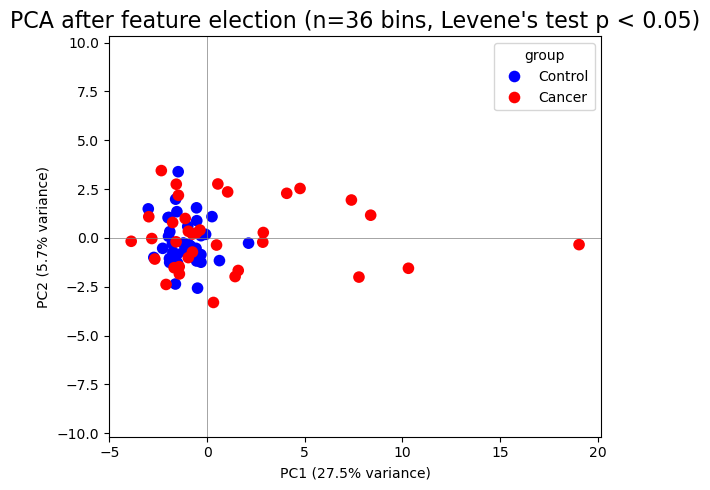

In [87]:
# PCA nur mit den signifikanten Bins (levene < 0.05)
significant_bins = bin_statistics_df.query("p_value_levene < 0.05")["bin"].tolist()

if len(significant_bins) == 0:
    print("⚠️ Keine signifikanten Bins gefunden!")
else:
    X = final_feature_matrix[significant_bins]
    y = final_feature_matrix["group"]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    explained_variance = pca.explained_variance_ratio_ * 100

    pca = PCA(n_components=2)
    pcs = pca.fit_transform(X_scaled)

    pca_df = pd.DataFrame(pcs, columns=["PC1","PC2"])
    pca_df["group"] = y.values
    pca_df["sample"] = final_feature_matrix.index

    plt.figure(figsize=(6,5))
    sns.scatterplot(
        x="PC1", y="PC2", hue="group",
        palette={"Cancer": "red", "Control": "blue"},
        data=pca_df, s=70, edgecolor="none"
    )
    plt.xlabel(f'PC1 ({explained_variance[0]:.1f}% variance)')
    plt.ylabel(f'PC2 ({explained_variance[1]:.1f}% variance)')
    plt.axhline(0, color="grey", linewidth=0.5)
    plt.axvline(0, color="grey", linewidth=0.5)
    plt.axis("equal")
    plt.title(f"PCA after feature election (n={len(significant_bins)} bins, Levene's test p < 0.05)", fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
# 1. Verteilung der WPS Werte über alle Bins pro Gruppe
plt.figure(figsize=(10,6))
sns.histplot(
    data=combined_df,
    x='wps_value',
    hue='group',
    bins=100,
    element='step',
    stat='density',
    common_norm=False,
    palette={"Cancer": "red", "Control": "blue"},
    alpha=0.5
)

In [ ]:
# WPS mean per sample calculated with first DF (Sample, start, end, wps-value...)
chrom_means = (
    combined_df.groupby(['sample', 'chrom'])['wps_value']
      .mean()
      .reset_index(name='mean_wps_per_chrom')
)

sample_means = (
    chrom_means.groupby('sample')['mean_wps_per_chrom']
               .mean()
               .reset_index(name='overall_mean_wps')
)

print(sample_means)
print(chrom_means)

     sample  overall_mean_wps
0   EE87935         -0.161842
1   EE87936         -0.181417
2   EE87937         -0.188242
3   EE87938         -0.168567
4   EE87939         -0.168139
..      ...               ...
65  EE88320         -0.152923
66  EE88321         -0.151172
67  EE88322         -0.174156
68  EE88323         -0.221034
69  EE88324         -0.165796

[70 rows x 2 columns]
       sample  chrom  mean_wps_per_chrom
0     EE87935   chr1           -0.166496
1     EE87935  chr10           -0.147438
2     EE87935  chr12           -0.165387
3     EE87935  chr13           -0.162309
4     EE87935  chr14           -0.159909
...       ...    ...                 ...
1325  EE88324   chr5           -0.165900
1326  EE88324   chr6           -0.170974
1327  EE88324   chr7           -0.162968
1328  EE88324   chr8           -0.171872
1329  EE88324   chr9           -0.156504

[1330 rows x 3 columns]


In [ ]:
# 3. Genome Wide analysis: mean WPS value for every sample weighted by chromosome length 

weighted_results = []

for sample in combined_df['sample'].unique():
    sample_data = combined_df[combined_df['sample'] == sample]
    group = sample_data.iloc[0]['group']

    bw_file = os.path.join(base_results_dir, f"{sample}.wps.bw")
    match = re.match(r'(EE\d{5})', sample)
    if match:
        sample_number = match.group(1)  
        bw_file = os.path.join(base_results_dir, f"{sample_number}.wps.bw")


        if os.path.exists(bw_file):
            bw = pyBigWig.open(bw_file)
            chrom_lengths = bw.chroms()
            bw.close()
            
            total_weighted_sum = 0
            total_length = 0

            sample_chrom_means = chrom_means[chrom_means['sample'] == sample]

            for _, row in sample_chrom_means.iterrows():
                chrom = row['chrom']
                mean_wps = row['mean_wps_per_chrom']
                length = chrom_lengths.get(chrom, 0)

                if length > 0:  
                    total_weighted_sum += mean_wps * length
                    total_length += length

            weighted_mean = total_weighted_sum / total_length if total_length > 0 else 0

            weighted_results.append({
                'Sample': sample,
                'Group': group,
                'weighted_mean_wps': weighted_mean
            })
        else:
            print(f"BigWig file not found: {bw_file}")

df_weighted = pd.DataFrame(weighted_results)
print("Gewichtete Mittelwerte pro Sample:")

print(df_weighted)


Gewichtete Mittelwerte pro Sample:
     Sample    Group  weighted_mean_wps
0   EE88290   Cancer          -0.169286
1   EE88291   Cancer          -0.217796
2   EE88292   Cancer          -0.171182
3   EE88293   Cancer          -0.157046
4   EE88294   Cancer          -0.405028
..      ...      ...                ...
65  EE87966  Control          -0.148878
66  EE87967  Control          -0.157921
67  EE87968  Control          -0.161563
68  EE87969  Control          -0.158300
69  EE87970  Control          -0.166831

[70 rows x 3 columns]


In [ ]:
df_weighted.to_parquet("df_weighted.parquet", index=False)

In [ ]:
# 3. Genome wide anaylsis without FDR

cancer_all_wps = df_weighted[df_weighted['Group'] == 'Cancer']['weighted_mean_wps']
control_all_wps = df_weighted[df_weighted['Group'] == 'Control']['weighted_mean_wps']

genome_t_stat, genome_p_value = ttest_ind(cancer_all_wps, control_all_wps)
print(f"Genomweiter T-Test: t-statistic = {genome_t_stat:.4f}, p-value = {genome_p_value:.4f}")
if genome_p_value < 0.05:
    print("→ SIGNIFIKANT: Genomweiter Unterschied zwischen Cancer und Control")
else:
    print("→ NICHT SIGNIFIKANT: Kein genomweiter Unterschied")

genome_results_df = pd.DataFrame({
    'analysis_level': ['Genome-wide'],
    'test_type': ['T-Test'],
    'n_tests': [1],
    't_statistic': [genome_t_stat],
    'p_value': [genome_p_value],
    'significant': [genome_p_value < 0.05],
    'fdr_applied': [False],
    'n_cancer_samples': [len(cancer_all_wps)],
    'n_control_samples': [len(control_all_wps)],
    'cancer_mean': [cancer_all_wps.mean()],
    'control_mean': [control_all_wps.mean()],
    'effect_size': [abs(cancer_all_wps.mean() - control_all_wps.mean())]
})

print("\nGenomweite Analyse Ergebnisse:")
print(genome_results_df)


Genomweiter T-Test: t-statistic = -3.1203, p-value = 0.0027
→ SIGNIFIKANT: Genomweiter Unterschied zwischen Cancer und Control

Genomweite Analyse Ergebnisse:
  analysis_level test_type  n_tests  t_statistic   p_value  significant  \
0    Genome-wide    T-Test        1    -3.120253  0.002651         True   

   fdr_applied  n_cancer_samples  n_control_samples  cancer_mean  \
0        False                35                 35    -0.189666   

   control_mean  effect_size  
0     -0.161328     0.028338  


/tmp/ipykernel_281228/3626954454.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_weighted, x='Group', y='weighted_mean_wps', inner='quartile',palette=["#FF6347", "#4682B4"])


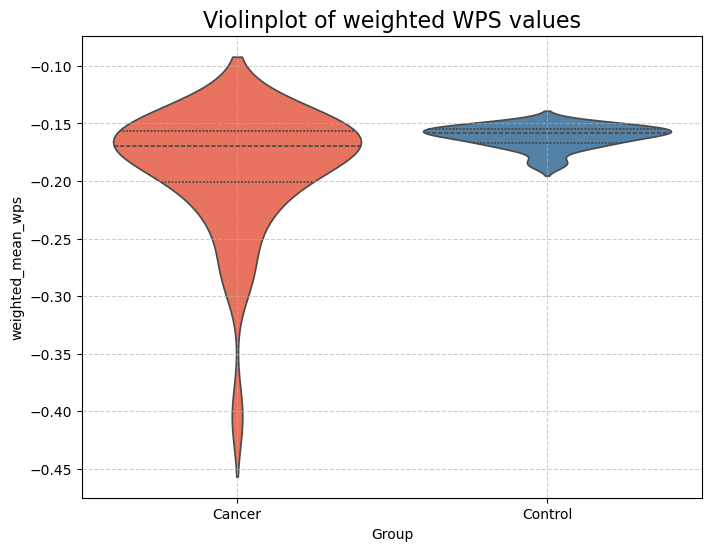

In [ ]:
# 3. Violin Plot genome wide analysis
plt.figure(figsize=(8, 6))
sns.violinplot(data=df_weighted, x='Group', y='weighted_mean_wps', inner='quartile',palette=["#FF6347", "#4682B4"])
plt.title('Violinplot of weighted WPS values', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

/tmp/ipykernel_281228/826815820.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_weighted, x='Group', y='weighted_mean_wps', palette=["#FF6347", "#4682B4"])


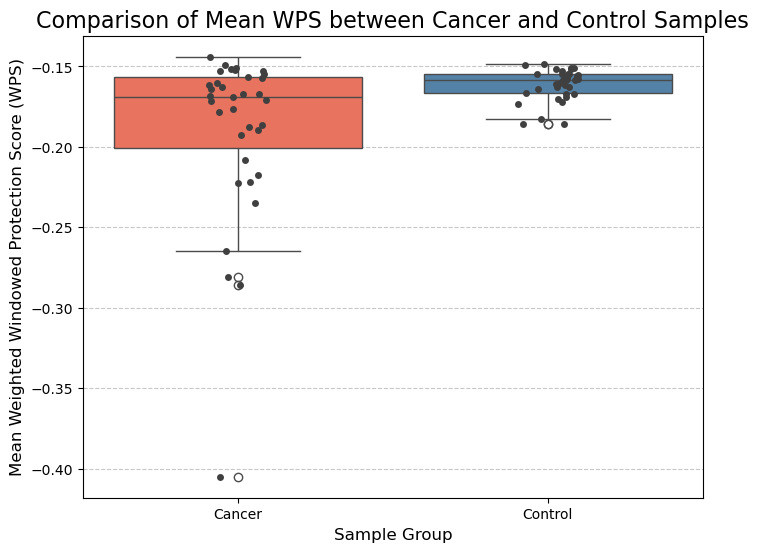

In [ ]:
# 3. Boxplot genome wide analysis
plt.figure(figsize=(8, 6)) 
sns.boxplot(data=df_weighted, x='Group', y='weighted_mean_wps', palette=["#FF6347", "#4682B4"])
sns.stripplot(data=df_weighted, x='Group', y='weighted_mean_wps', color=".25")
plt.title('Comparison of Mean WPS between Cancer and Control Samples', fontsize=16)
plt.xlabel('Sample Group', fontsize=12)
plt.ylabel('Mean Weighted Windowed Protection Score (WPS)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<Axes: xlabel='weighted_mean_wps', ylabel='Density'>

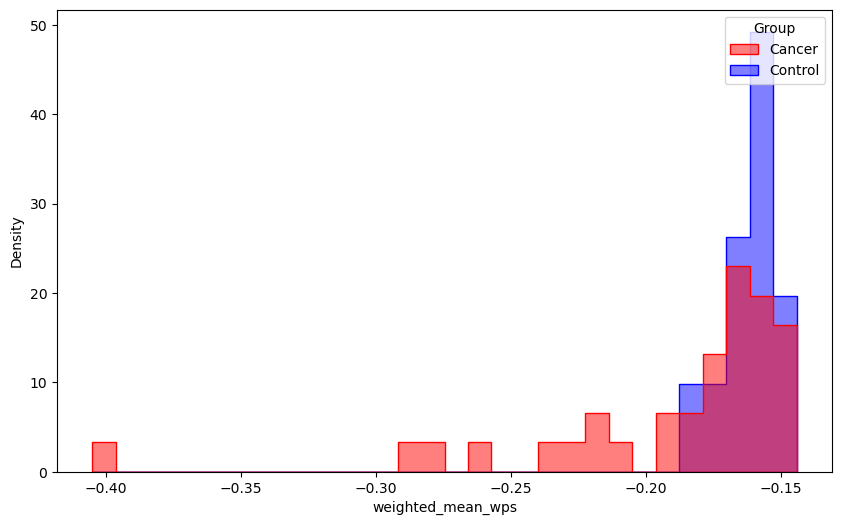

In [ ]:
# 3. Verteilung der WPS Werte genome wide
plt.figure(figsize=(10,6))
sns.histplot(
    data=df_weighted,
    x='weighted_mean_wps',
    hue='Group',
    bins=30,
    element='step',
    stat='density',
    common_norm=False,
    palette={"Cancer": "red", "Control": "blue"},
    alpha=0.5
)

In [ ]:
# T-Test genome wide analysis

cancer_wps = df_weighted[df_weighted['Group'] == 'Cancer']['weighted_mean_wps']
control_wps = df_weighted[df_weighted['Group'] == 'Control']['weighted_mean_wps']

if len(cancer_wps) > 1 and len(control_wps) > 1:
    t_stat, p_value = ttest_ind(cancer_wps, control_wps, nan_policy='omit')

    print(f"T-Test Results:")
    print(f"  t-statistic: {t_stat:.4f}")
    # (Unterschied zwischen den Gruppen) / (Streuung innerhalb der Gruppen): großer Wert bedeutet großes Signal
    print(f"  P-value: {p_value:.4f}")
    # Wie wahrscheinlich ist es, durch Zufall ein solches Ergebnis zu sehen? Je kleiner der p-Wert desto
    # kleiner ist die Wahrscheinlichkeit, und deswegen besser wenn man die Nullhypothese "Es gibt keinen 
    # Unterschied" ablehnt 
    levene_stat, levene_p_value = levene(cancer_wps, control_wps, center='median')
    print(f"Levene Stat: ", levene_stat, f" levene P-value: ", levene_p_value)
    if p_value < 0.05:
        print("\nInterpretation: The difference between the groups is statistically significant (p < 0.05).")
    else:
        print("\nInterpretation: The difference between the groups is not statistically significant (p >= 0.05).")
else:
    print("Not enough data available for a T-test.")

T-Test Results:
  t-statistic: -3.1203
  P-value: 0.0027
Levene Stat:  9.736877730882174  levene P-value:  0.0026500651400332346

Interpretation: The difference between the groups is statistically significant (p < 0.05).


  Coeffizient for weighted mean_wps: -4.4196
  Intercept: -0.2756
A lower WPS value is associated with a higher probability of 'cancer' (label=1).
 -> This corresponds to the biological hypothesis!


/home/lotta/miniconda3/envs/fragmentomics_analysis/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


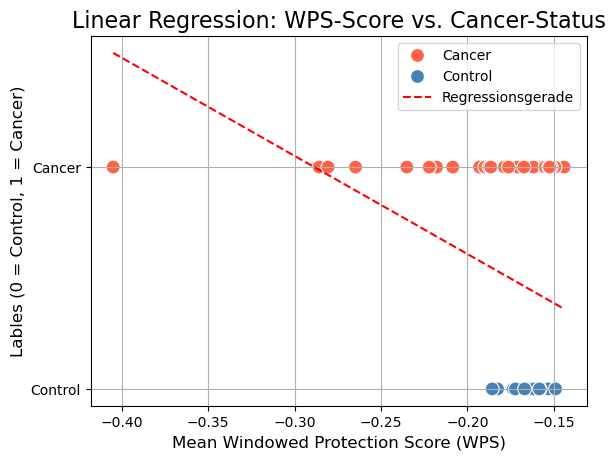

In [ ]:
# Linear Regression WPS ~ Cancer/Control
df_weighted['Label'] = df_weighted['Group'].apply(lambda x: 1 if x == 'Cancer' else 0)
X = df_weighted[['weighted_mean_wps']]
y = df_weighted['Label']

model = LinearRegression()
model.fit(X,y)

coefficient = model.coef_[0]
intercept = model.intercept_
print(f"  Coeffizient for weighted mean_wps: {coefficient:.4f}")
print(f"  Intercept: {intercept:.4f}")

if coefficient < 0:
    print("A lower WPS value is associated with a higher probability of 'cancer' (label=1).")
    print(" -> This corresponds to the biological hypothesis!")
elif coefficient > 0:
    print(" A HIGHER WPS value is associated with a higher probability of 'cancer' (label=1).")
    print(" -> This contradicts the biological hypothesis and could indicate problems in the data.")
else:
    print("The WPS value does not appear to have a linear influence on the classification.")
    
    plt.figure(figsize=(10,6))

color_palette = {"Cancer": "#FF6347", "Control": "#4682B4"}

sns.scatterplot(data=df_weighted, x='weighted_mean_wps', y='Label', hue='Group', s=100, palette=color_palette)

x_fit = np.linspace(X['weighted_mean_wps'].min(), X['weighted_mean_wps'].max(), 100).reshape(-1, 1)
y_fit = model.predict(x_fit)

plt.plot(x_fit, y_fit, color='red', linestyle='--', label='Regressionsgerade')

plt.title('Linear Regression: WPS-Score vs. Cancer-Status', fontsize=16)
plt.xlabel('Mean Windowed Protection Score (WPS)', fontsize=12)
plt.ylabel('Lables (0 = Control, 1 = Cancer)', fontsize=12)
plt.yticks([0, 1], ['Control', 'Cancer']) 
plt.legend()
plt.grid(True)
plt.show()

Datensatz aufgeteilt: 56 Trainingsproben und 14 Testproben.

Ergebnisse des auf Trainingsdaten trainierten Modells:
  Coeffizient (Steigung) für mean_wps: -5.8650
  Intercept : -0.5524


/home/lotta/miniconda3/envs/fragmentomics_analysis/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


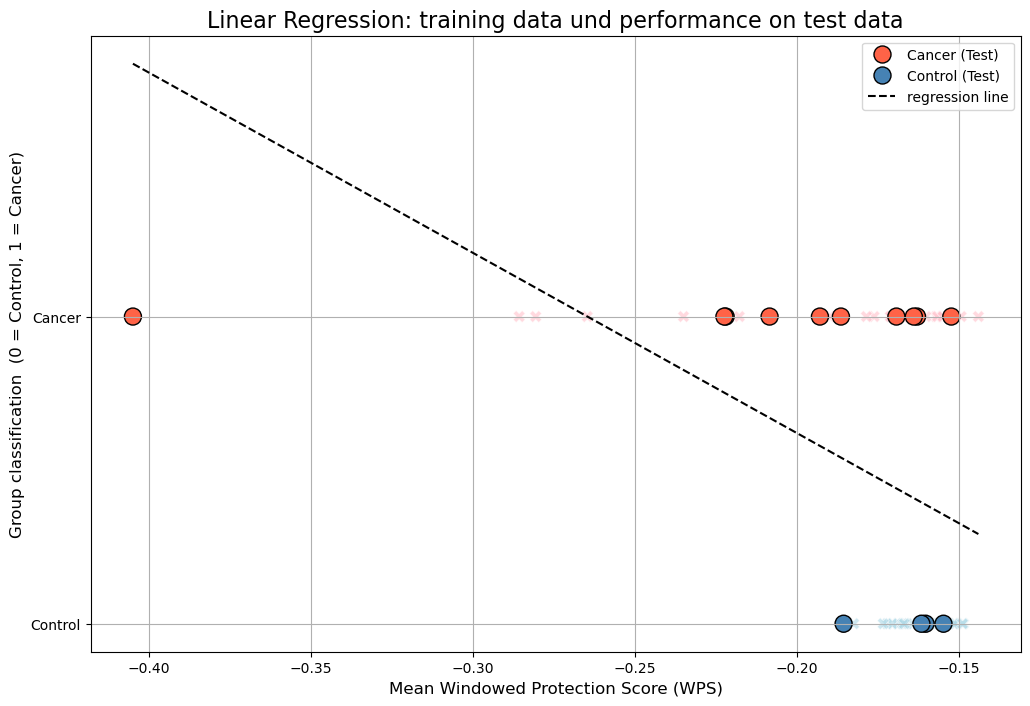

In [ ]:
# Liear Regression with Train-Test-Split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


df_weighted['Label'] = df_weighted['Group'].apply(lambda x: 1 if x == 'Cancer' else 0)

X = df_weighted[['weighted_mean_wps']] 
y = df_weighted['Label']

# 2. Train-Test-Split (Der neue, wichtige Schritt)
# Wir teilen die Daten zufällig in 80% für das Training und 20% für das Testen auf.
# random_state=42 sorgt dafür, dass die Aufteilung immer gleich ist, wenn du den Code erneut ausführst (Reproduzierbarkeit).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Datensatz aufgeteilt: {len(X_train)} Trainingsproben und {len(X_test)} Testproben.")

# 3. Lineares Regressionsmodell erstellen und NUR auf den Trainingsdaten trainieren
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Ergebnisse des trainierten Modells ausgeben (wie zuvor)
coefficient = model.coef_[0]
intercept = model.intercept_
print(f"\nErgebnisse des auf Trainingsdaten trainierten Modells:")
print(f"  Coeffizient (Steigung) für mean_wps: {coefficient:.4f}")
print(f"  Intercept : {intercept:.4f}")


# 5. Visualisierung: Zeige Trainingsdaten und die Performance auf den Testdaten

plt.figure(figsize=(12, 8))

# --- PLOTTE DIE TRAININGS-DATEN (NEUER TEIL) ---
# Erstelle einen temporären DataFrame für die Trainingsdaten zum Plotten
train_data_df = pd.DataFrame(X_train).copy()
train_data_df['Label'] = y_train
train_data_df['Group'] = train_data_df['Label'].apply(lambda x: 'Cancer' if x == 1 else 'Control')

# Scatter-Plot der Trainings-Datenpunkte
# Wir verwenden hellere Farben und machen die Punkte kleiner und leicht transparent (alpha=0.6)
sns.scatterplot(data=train_data_df, x='weighted_mean_wps', y='Label', hue='Group', 
                palette={"Cancer": "#FFC0CB", "Control": "#ADD8E6"}, # Hell-Pink/Hell-Blau
                s=75, alpha=0.6, marker="X")


# --- PLOTTE DIE TEST-DATEN (WIE ZUVOR) ---
# Erstelle den DataFrame für die Testdaten
test_data_df = pd.DataFrame(X_test).copy()
test_data_df['Label'] = y_test
test_data_df['Group'] = test_data_df['Label'].apply(lambda x: 'Cancer' if x == 1 else 'Control')

# Scatter-Plot der Test-Datenpunkte in kräftigen Farben
sns.scatterplot(data=test_data_df, x='weighted_mean_wps', y='Label', hue='Group', 
                palette=color_palette, 
                s=150, ec='black', linewidth=1) # Mit schwarzem Rand zur Hervorhebung


# --- PLOTTE DIE REGRESSIONSGERADE (WIE ZUVOR) ---
# Generiere und plotte die Linie basierend auf dem trainierten Modell
x_fit = np.linspace(X['weighted_mean_wps'].min(), X['weighted_mean_wps'].max(), 100).reshape(-1, 1)
y_fit = model.predict(x_fit)
plt.plot(x_fit, y_fit, color='black', linestyle='--', label='regression line (trained on training data)')


# --- AUFRÄUMEN UND BESCHRIFTEN ---
# Titel und Achsenbeschriftungen
plt.title('Linear Regression: training data und performance on test data', fontsize=16)
plt.xlabel('Mean Windowed Protection Score (WPS)', fontsize=12)
plt.ylabel('Group classification  (0 = Control, 1 = Cancer)', fontsize=12)
plt.yticks([0, 1], ['Control', 'Cancer']) 

# Legende anpassen (kann etwas knifflig sein, wenn man mehrere Plots kombiniert)
# Wir holen uns die Handles und Labels und erstellen eine saubere Legende
handles, labels = plt.gca().get_legend_handles_labels()
# Wir wollen nur die Einträge für Testdaten und die Linie, die ersten (Trainingsdaten) Einträge ignorieren wir.
# Passe die Indizes an, je nachdem wie viele Gruppen du hast.
plt.legend(handles=[handles[2], handles[3], handles[4]], labels=['Cancer (Test)', 'Control (Test)', 'regression line'])

plt.grid(True)
plt.show()